In [1]:
import random
import varseek as vk
import os
import sys
import anndata as ad
import subprocess
import numpy as np
import pandas as pd

from varseek.utils import build_random_genome_read_df, fasta_to_fastq, create_mutant_t2g, fasta_to_fastq, find_genes_with_aligned_reads_for_kb_extract, calculate_metrics, create_stratified_metric_bar_plot, create_venn_diagram, get_header_set_from_fastq, plot_histogram, synthetic_data_summary_plot, plot_basic_bar_plot_from_dict, draw_confusion_matrix, check_for_read_kmer_in_mcrs

In [2]:
out_dir_notebook="/home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59" #!!! change for each run
number_of_mutations_to_sample = 5000



read_length = 150
strand = None  # None for strand-agnostic (randomly-selected), "f" for forward, "r" for reverse, "both" for both - make sure this matches the reference genome (vk build command) - strand = True -> "f" or "r" here; strand = False -> None or "both" here - note that the strand is randomly selected per *transcript*, such that all drawn reads will come from the same strand no matter what
add_noise=False
error_rate=0
max_errors=0
seq_id_column="seq_ID"
mut_column="mutation"
threads = 8
check_reason_for_read_fn = False

k = 59  # w=54 - even if I will use k=59 in my experiments, my synthetic data is designed so that w=(read_length-1), meaning that the mutation can be anywhere on the read from the first to the last nucleotide, and thus I cannot catch these edge mutations if k > (w+1) - if I want to run where k > w+1, then adjust w internal to vk sim accoringly
w = 54

# Paths
mutation_metadata_df = "/home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov13/mutation_metadata_df_updated_vk_info_exploded.csv"
mutation_index = "/home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov13/mutation_reference.idx"
mutation_t2g = "/home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov13/t2g_filtered.txt"

sequences = "/home/jrich/data/varseek_data_fresh/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.cdna.all.fa"
reference_out_dir = "/home/jrich/data/varseek_data_fresh/reference"

In [3]:
out_dir_vk_build = f"{out_dir_notebook}/vk_build"

synthetic_reads_fastQ = f"{out_dir_notebook}/synthetic_reads.fq"
read_df_out = f"{out_dir_notebook}/synthetic_reads.csv"
mutation_metadata_df_out = f"{out_dir_notebook}/mutation_metadata_df_updated_vk_info_exploded_with_synthetic_read_info.csv"

kb_count_out = f"{out_dir_notebook}/kb_count_out"



seed=42
read_df = None
mutation_metadata_df_path = mutation_metadata_df
adata_path = f"{kb_count_out}/counts_unfiltered/adata.h5ad"

read_df_out_updated = read_df_out.replace(".csv", "_updated.csv")
unique_mcrs_df_out = f"{out_dir_notebook}/unique_mcrs_df.csv"

plot_output_folder = f"{out_dir_notebook}/plots"
os.makedirs(plot_output_folder, exist_ok=True)

In [4]:
# # run vk ref or notebook 1_1 (vk build, vk info with save_exploded_df=True, vk filter, kb ref)

# Simple synthetic reads - erase

In [5]:
# #!!! TEMP
# import varseek
# mutation_metadata_df_path = mutation_metadata_df
# mutation_metadata_df = pd.read_csv(mutation_metadata_df_path)

# sim_data_df_path = "/home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_temp2/vk_build/sim_data_df.csv"
# sim_data_df = pd.read_csv(sim_data_df_path, usecols=["header", "mutant_sequence", "wt_sequence"])

# sim_data_df.rename(
#     columns={
#         "mutant_sequence": "mutant_sequence_read_parent",
#         "wt_sequence": "wt_sequence_read_parent",
#     },
#     inplace=True,
# )

# sim_data_df["mutant_sequence_read_parent_rc"] = sim_data_df["mutant_sequence_read_parent"].apply(varseek.varseek_build.reverse_complement)
# sim_data_df["mutant_sequence_read_parent_length"] = sim_data_df["mutant_sequence_read_parent"].str.len()

# sim_data_df["wt_sequence_read_parent_rc"] = sim_data_df["wt_sequence_read_parent"].apply(varseek.varseek_build.reverse_complement)
# sim_data_df["wt_sequence_read_parent_length"] = sim_data_df["wt_sequence_read_parent"].str.len()

# mutation_metadata_df = pd.merge(
#     mutation_metadata_df,
#     sim_data_df[
#         [
#             "header",
#             "mutant_sequence_read_parent",
#             "mutant_sequence_read_parent_rc",
#             "mutant_sequence_read_parent_length",
#             "wt_sequence_read_parent",
#             "wt_sequence_read_parent_rc",
#             "wt_sequence_read_parent_length",
#         ]
#     ],
#     on="header",
#     how="left",
#     suffixes=("", "_read_parent"),
# )

In [6]:
import sys
import importlib

# Remove the module from sys.modules
if 'varseek.sim' in sys.modules:
    del sys.modules['varseek.sim']

# Import the module and reload it
import varseek.varseek_sim
importlib.reload(varseek.varseek_sim)
import varseek as vk

# instead of using vk.sim() as before, I must explicitely use vk.varseek_sim.sim()

In [7]:
#!!! TEMP
sample_type = "all"
conditions = ['dlist-equal=none', 'kmer_overlap_in_mcrs_reference-isfalse']


if not os.path.exists(mutation_metadata_df_out) or not os.path.exists(read_df_out):
    simulated_df_dict = vk.varseek_sim.sim(
        mutation_metadata_df = mutation_metadata_df,
        fastq_output_path = synthetic_reads_fastQ,
        sample_type=sample_type,
        number_of_mutations_to_sample=number_of_mutations_to_sample,
        strand=strand,
        number_of_reads_per_sample="all",  # not used when number_of_reads_per_sample_m and number_of_reads_per_sample_w are provided
        k=k,  # used in vk build with the respective index
        w=w,  # used in vk build with the respective index
        read_length=read_length,
        seed=seed,
        add_noise=add_noise,
        error_rate=error_rate,
        max_errors=max_errors,
        with_replacement=False,
        sequences=sequences,
        mutation_metadata_df_path=mutation_metadata_df_path,
        seq_id_column=seq_id_column,
        mut_column=mut_column,
        reference_out_dir=reference_out_dir,
        out_dir_vk_build=out_dir_vk_build,
        filters=conditions,
        read_df_out=read_df_out,
        mutation_metadata_df_out=mutation_metadata_df_out,
    )

    read_df, mutation_metadata_df = simulated_df_dict["read_df"], simulated_df_dict["mutation_metadata_df"]
else:
    read_df = pd.read_csv(read_df_out)
    mutation_metadata_df = pd.read_csv(mutation_metadata_df_out)

/home/jrich/Desktop/varseek/varseek/varseek_sim.py:114: DtypeWarning: Columns (12,53,68,70) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_metadata_df = pd.read_csv(mutation_metadata_df)


cannot find mutant sequence read parent
running varseek build


/home/jrich/Desktop/varseek/varseek/varseek_build.py:638: DtypeWarning: Columns (12,53,68,70) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations = pd.read_csv(mutations)


Extracting MCRS left flank sequences:   0%|                                                      | 0/5343215 [00:00<?, ?it/s]

Extracting MCRS left flank sequences:   0%|                                        | 1/5343215 [00:19<29259:33:23, 19.71s/it]

Extracting MCRS left flank sequences:   0%|                                       | 10635/5343215 [00:19<1:56:09, 765.11it/s]

Extracting MCRS left flank sequences:   0%|▏                                       | 21959/5343215 [00:19<46:26, 1909.34it/s]

Extracting MCRS left flank sequences:   1%|▏                                       | 33059/5343215 [00:20<25:29, 3472.07it/s]

Extracting MCRS left flank sequences:   1%|▎                                       | 44411/5343215 [00:20<15:33, 5678.95it/s]

Extracting MCRS left flank sequences:   1%|▍                                       | 55823/5343215 [00:20<10:07, 8699.09it/s]

Extracting MCRS left flank sequences:   1%|▍                                      | 67087/5343215 [00:20<06:56, 12664.82it/s]

Extracting MCRS left flank sequences:   1%|▌                                      | 78591/5343215 [00:20<04:53, 17966.31it/s]

Extracting MCRS left flank sequences:   2%|▋                                      | 89874/5343215 [00:20<03:34, 24494.29it/s]

Extracting MCRS left flank sequences:   2%|▋                                     | 101143/5343215 [00:20<02:42, 32332.76it/s]

Extracting MCRS left flank sequences:   2%|▊                                     | 112631/5343215 [00:20<02:05, 41680.81it/s]

Extracting MCRS left flank sequences:   2%|▉                                     | 124114/5343215 [00:20<01:40, 51866.86it/s]

Extracting MCRS left flank sequences:   3%|▉                                     | 135637/5343215 [00:20<01:23, 62379.80it/s]

Extracting MCRS left flank sequences:   3%|█                                     | 147037/5343215 [00:21<01:12, 72049.20it/s]

Extracting MCRS left flank sequences:   3%|█▏                                    | 158482/5343215 [00:21<01:03, 81139.41it/s]

Extracting MCRS left flank sequences:   3%|█▏                                    | 169858/5343215 [00:21<00:58, 88569.61it/s]

Extracting MCRS left flank sequences:   3%|█▎                                    | 181198/5343215 [00:21<00:55, 93728.59it/s]

Extracting MCRS left flank sequences:   4%|█▎                                    | 192571/5343215 [00:21<00:52, 98954.26it/s]

Extracting MCRS left flank sequences:   4%|█▍                                   | 203818/5343215 [00:21<00:50, 102307.97it/s]

Extracting MCRS left flank sequences:   4%|█▍                                   | 215314/5343215 [00:21<00:48, 105837.37it/s]

Extracting MCRS left flank sequences:   4%|█▌                                   | 226815/5343215 [00:21<00:47, 108450.45it/s]

Extracting MCRS left flank sequences:   4%|█▋                                   | 238172/5343215 [00:21<00:46, 109515.91it/s]

Extracting MCRS left flank sequences:   5%|█▋                                   | 249747/5343215 [00:21<00:45, 111333.84it/s]

Extracting MCRS left flank sequences:   5%|█▊                                   | 261268/5343215 [00:22<00:45, 112473.76it/s]

Extracting MCRS left flank sequences:   5%|█▉                                   | 272699/5343215 [00:22<00:45, 112531.74it/s]

Extracting MCRS left flank sequences:   5%|█▉                                   | 284244/5343215 [00:22<00:44, 113394.80it/s]

Extracting MCRS left flank sequences:   6%|██                                   | 295690/5343215 [00:22<00:44, 113711.14it/s]

Extracting MCRS left flank sequences:   6%|██▏                                  | 307125/5343215 [00:22<00:44, 113025.17it/s]

Extracting MCRS left flank sequences:   6%|██▏                                  | 318597/5343215 [00:22<00:44, 113526.43it/s]

Extracting MCRS left flank sequences:   6%|██▎                                  | 330155/5343215 [00:22<00:43, 114138.13it/s]

Extracting MCRS left flank sequences:   6%|██▎                                  | 341592/5343215 [00:22<00:45, 110568.84it/s]

Extracting MCRS left flank sequences:   7%|██▍                                  | 352689/5343215 [00:22<00:46, 108470.83it/s]

Extracting MCRS left flank sequences:   7%|██▌                                  | 364153/5343215 [00:22<00:45, 110261.21it/s]

Extracting MCRS left flank sequences:   7%|██▌                                  | 375717/5343215 [00:23<00:44, 111836.68it/s]

Extracting MCRS left flank sequences:   7%|██▋                                  | 387186/5343215 [00:23<00:43, 112676.75it/s]

Extracting MCRS left flank sequences:   7%|██▊                                  | 398472/5343215 [00:23<00:44, 110592.53it/s]

Extracting MCRS left flank sequences:   8%|██▊                                  | 409850/5343215 [00:23<00:44, 111526.16it/s]

Extracting MCRS left flank sequences:   8%|██▉                                  | 421038/5343215 [00:23<00:44, 111629.34it/s]

Extracting MCRS left flank sequences:   8%|██▉                                  | 432289/5343215 [00:23<00:43, 111890.39it/s]

Extracting MCRS left flank sequences:   8%|███                                  | 443486/5343215 [00:23<00:43, 111730.49it/s]

Extracting MCRS left flank sequences:   9%|███▏                                 | 454665/5343215 [00:23<00:44, 110565.77it/s]

Extracting MCRS left flank sequences:   9%|███▏                                 | 466230/5343215 [00:23<00:43, 112071.88it/s]

Extracting MCRS left flank sequences:   9%|███▎                                 | 477828/5343215 [00:23<00:42, 113233.05it/s]

Extracting MCRS left flank sequences:   9%|███▍                                 | 489157/5343215 [00:24<00:43, 112769.99it/s]

Extracting MCRS left flank sequences:   9%|███▍                                 | 500770/5343215 [00:24<00:42, 113770.49it/s]

Extracting MCRS left flank sequences:  10%|███▌                                 | 512297/5343215 [00:24<00:42, 114215.95it/s]

Extracting MCRS left flank sequences:  10%|███▋                                 | 523722/5343215 [00:24<00:42, 113487.56it/s]

Extracting MCRS left flank sequences:  10%|███▋                                 | 535331/5343215 [00:24<00:42, 114262.39it/s]

Extracting MCRS left flank sequences:  10%|███▊                                 | 546760/5343215 [00:24<00:42, 113410.11it/s]

Extracting MCRS left flank sequences:  10%|███▊                                 | 558268/5343215 [00:24<00:42, 113906.10it/s]

Extracting MCRS left flank sequences:  11%|███▉                                 | 569747/5343215 [00:24<00:41, 114169.36it/s]

Extracting MCRS left flank sequences:  11%|████                                 | 581166/5343215 [00:24<00:42, 113201.10it/s]

Extracting MCRS left flank sequences:  11%|████                                 | 592630/5343215 [00:24<00:41, 113626.18it/s]

Extracting MCRS left flank sequences:  11%|████▏                                | 604131/5343215 [00:25<00:41, 114038.49it/s]

Extracting MCRS left flank sequences:  12%|████▎                                | 615537/5343215 [00:25<00:41, 113230.51it/s]

Extracting MCRS left flank sequences:  12%|████▎                                | 626956/5343215 [00:25<00:41, 113514.85it/s]

Extracting MCRS left flank sequences:  12%|████▍                                | 638403/5343215 [00:25<00:41, 113798.34it/s]

Extracting MCRS left flank sequences:  12%|████▍                                | 649785/5343215 [00:25<00:41, 113187.35it/s]

Extracting MCRS left flank sequences:  12%|████▌                                | 661106/5343215 [00:25<00:41, 112477.34it/s]

Extracting MCRS left flank sequences:  13%|████▋                                | 672356/5343215 [00:25<00:41, 112466.41it/s]

Extracting MCRS left flank sequences:  13%|████▋                                | 683604/5343215 [00:25<00:42, 109329.61it/s]

Extracting MCRS left flank sequences:  13%|████▊                                | 694556/5343215 [00:25<00:42, 108279.96it/s]

Extracting MCRS left flank sequences:  13%|████▉                                | 705397/5343215 [00:26<00:45, 101375.65it/s]

Extracting MCRS left flank sequences:  13%|████▉                                | 716784/5343215 [00:26<00:44, 104890.53it/s]

Extracting MCRS left flank sequences:  14%|█████                                | 728216/5343215 [00:26<00:42, 107593.32it/s]

Extracting MCRS left flank sequences:  14%|█████                                | 739129/5343215 [00:26<00:42, 108039.67it/s]

Extracting MCRS left flank sequences:  14%|█████▏                               | 750247/5343215 [00:26<00:42, 108960.52it/s]

Extracting MCRS left flank sequences:  14%|█████▎                               | 761182/5343215 [00:26<00:42, 108021.28it/s]

Extracting MCRS left flank sequences:  14%|█████▎                               | 772012/5343215 [00:26<00:42, 107729.63it/s]

Extracting MCRS left flank sequences:  15%|█████▍                               | 782804/5343215 [00:26<00:42, 106481.83it/s]

Extracting MCRS left flank sequences:  15%|█████▍                               | 793634/5343215 [00:26<00:42, 107016.75it/s]

Extracting MCRS left flank sequences:  15%|█████▌                               | 805100/5343215 [00:26<00:41, 109279.03it/s]

Extracting MCRS left flank sequences:  15%|█████▋                               | 816174/5343215 [00:27<00:41, 109712.39it/s]

Extracting MCRS left flank sequences:  15%|█████▋                               | 827634/5343215 [00:27<00:40, 111167.94it/s]

Extracting MCRS left flank sequences:  16%|█████▊                               | 839107/5343215 [00:27<00:40, 112229.33it/s]

Extracting MCRS left flank sequences:  16%|█████▉                               | 850336/5343215 [00:27<00:40, 111309.37it/s]

Extracting MCRS left flank sequences:  16%|█████▉                               | 861769/5343215 [00:27<00:39, 112208.13it/s]

Extracting MCRS left flank sequences:  16%|██████                               | 873123/5343215 [00:27<00:39, 112604.72it/s]

Extracting MCRS left flank sequences:  17%|██████                               | 884387/5343215 [00:27<00:39, 111557.60it/s]

Extracting MCRS left flank sequences:  17%|██████▏                              | 895547/5343215 [00:27<00:39, 111429.07it/s]

Extracting MCRS left flank sequences:  17%|██████▎                              | 906909/5343215 [00:27<00:39, 112078.76it/s]

Extracting MCRS left flank sequences:  17%|██████▎                              | 918120/5343215 [00:27<00:39, 111945.22it/s]

Extracting MCRS left flank sequences:  17%|██████▍                              | 929622/5343215 [00:28<00:39, 112861.38it/s]

Extracting MCRS left flank sequences:  18%|██████▌                              | 940910/5343215 [00:28<00:39, 112237.46it/s]

Extracting MCRS left flank sequences:  18%|██████▌                              | 952387/5343215 [00:28<00:38, 112991.37it/s]

Extracting MCRS left flank sequences:  18%|██████▋                              | 963740/5343215 [00:28<00:38, 113149.63it/s]

Extracting MCRS left flank sequences:  18%|██████▊                              | 975057/5343215 [00:28<00:38, 112850.53it/s]

Extracting MCRS left flank sequences:  18%|██████▊                              | 986475/5343215 [00:28<00:38, 113245.46it/s]

Extracting MCRS left flank sequences:  19%|██████▉                              | 997801/5343215 [00:28<00:38, 112488.38it/s]

Extracting MCRS left flank sequences:  19%|██████▊                             | 1009052/5343215 [00:28<00:39, 109771.33it/s]

Extracting MCRS left flank sequences:  19%|██████▉                             | 1020465/5343215 [00:28<00:38, 111048.85it/s]

Extracting MCRS left flank sequences:  19%|██████▉                             | 1031820/5343215 [00:28<00:38, 111785.45it/s]

Extracting MCRS left flank sequences:  20%|███████                             | 1043009/5343215 [00:29<00:38, 111200.84it/s]

Extracting MCRS left flank sequences:  20%|███████                             | 1054513/5343215 [00:29<00:38, 112337.17it/s]

Extracting MCRS left flank sequences:  20%|███████▏                            | 1065970/5343215 [00:29<00:38, 112224.77it/s]

Extracting MCRS left flank sequences:  20%|███████▎                            | 1077450/5343215 [00:29<00:37, 112987.70it/s]

Extracting MCRS left flank sequences:  20%|███████▎                            | 1088914/5343215 [00:29<00:37, 113478.82it/s]

Extracting MCRS left flank sequences:  21%|███████▍                            | 1100266/5343215 [00:29<00:37, 112816.90it/s]

Extracting MCRS left flank sequences:  21%|███████▍                            | 1111809/5343215 [00:29<00:37, 113593.64it/s]

Extracting MCRS left flank sequences:  21%|███████▌                            | 1123266/5343215 [00:29<00:37, 113882.71it/s]

Extracting MCRS left flank sequences:  21%|███████▋                            | 1134657/5343215 [00:29<00:37, 113375.68it/s]

Extracting MCRS left flank sequences:  21%|███████▋                            | 1146315/5343215 [00:29<00:36, 114329.02it/s]

Extracting MCRS left flank sequences:  22%|███████▊                            | 1157842/5343215 [00:30<00:36, 114608.55it/s]

Extracting MCRS left flank sequences:  22%|███████▉                            | 1169305/5343215 [00:30<00:38, 109297.69it/s]

Extracting MCRS left flank sequences:  22%|███████▉                            | 1180749/5343215 [00:30<00:37, 110784.01it/s]

Extracting MCRS left flank sequences:  22%|████████                            | 1192285/5343215 [00:30<00:37, 112120.09it/s]

Extracting MCRS left flank sequences:  23%|████████                            | 1203738/5343215 [00:30<00:36, 112828.97it/s]

Extracting MCRS left flank sequences:  23%|████████▏                           | 1215287/5343215 [00:30<00:36, 113616.38it/s]

Extracting MCRS left flank sequences:  23%|████████▎                           | 1226750/5343215 [00:30<00:36, 113916.74it/s]

Extracting MCRS left flank sequences:  23%|████████▎                           | 1238204/5343215 [00:30<00:35, 114100.99it/s]

Extracting MCRS left flank sequences:  23%|████████▍                           | 1249624/5343215 [00:30<00:36, 113177.52it/s]

Extracting MCRS left flank sequences:  24%|████████▍                           | 1261189/5343215 [00:30<00:35, 113909.99it/s]

Extracting MCRS left flank sequences:  24%|████████▌                           | 1272636/5343215 [00:31<00:35, 114075.60it/s]

Extracting MCRS left flank sequences:  24%|████████▋                           | 1284048/5343215 [00:31<00:35, 113413.62it/s]

Extracting MCRS left flank sequences:  24%|████████▋                           | 1295566/5343215 [00:31<00:35, 113937.64it/s]

Extracting MCRS left flank sequences:  24%|████████▊                           | 1306963/5343215 [00:31<00:35, 113289.55it/s]

Extracting MCRS left flank sequences:  25%|████████▉                           | 1318390/5343215 [00:31<00:35, 113580.52it/s]

Extracting MCRS left flank sequences:  25%|████████▉                           | 1329817/5343215 [00:31<00:35, 113784.75it/s]

Extracting MCRS left flank sequences:  25%|█████████                           | 1341198/5343215 [00:31<00:35, 112783.89it/s]

Extracting MCRS left flank sequences:  25%|█████████                           | 1352594/5343215 [00:31<00:35, 113131.31it/s]

Extracting MCRS left flank sequences:  26%|█████████▏                          | 1364124/5343215 [00:31<00:34, 113775.88it/s]

Extracting MCRS left flank sequences:  26%|█████████▎                          | 1375504/5343215 [00:31<00:35, 112678.67it/s]

Extracting MCRS left flank sequences:  26%|█████████▎                          | 1387002/5343215 [00:32<00:34, 113361.09it/s]

Extracting MCRS left flank sequences:  26%|█████████▋                           | 1398342/5343215 [00:32<00:40, 96651.54it/s]

Extracting MCRS left flank sequences:  26%|█████████▍                          | 1409748/5343215 [00:32<00:38, 101286.06it/s]

Extracting MCRS left flank sequences:  27%|█████████▌                          | 1421175/5343215 [00:32<00:37, 104862.12it/s]

Extracting MCRS left flank sequences:  27%|█████████▋                          | 1431943/5343215 [00:32<00:37, 104268.71it/s]

Extracting MCRS left flank sequences:  27%|█████████▋                          | 1442850/5343215 [00:32<00:36, 105635.36it/s]

Extracting MCRS left flank sequences:  27%|█████████▊                          | 1453558/5343215 [00:32<00:36, 106045.99it/s]

Extracting MCRS left flank sequences:  27%|█████████▊                          | 1464836/5343215 [00:32<00:35, 108014.07it/s]

Extracting MCRS left flank sequences:  28%|█████████▉                          | 1476235/5343215 [00:32<00:35, 109774.09it/s]

Extracting MCRS left flank sequences:  28%|██████████                          | 1487412/5343215 [00:33<00:34, 110364.51it/s]

Extracting MCRS left flank sequences:  28%|██████████                          | 1498853/5343215 [00:33<00:34, 111566.89it/s]

Extracting MCRS left flank sequences:  28%|██████████▏                         | 1510286/5343215 [00:33<00:34, 112390.34it/s]

Extracting MCRS left flank sequences:  28%|██████████▎                         | 1521547/5343215 [00:33<00:34, 112239.46it/s]

Extracting MCRS left flank sequences:  29%|██████████▎                         | 1533056/5343215 [00:33<00:33, 113089.09it/s]

Extracting MCRS left flank sequences:  29%|██████████▍                         | 1544471/5343215 [00:33<00:33, 113404.47it/s]

Extracting MCRS left flank sequences:  29%|██████████▍                         | 1555820/5343215 [00:33<00:33, 112888.45it/s]

Extracting MCRS left flank sequences:  29%|██████████▌                         | 1567359/5343215 [00:33<00:33, 113634.64it/s]

Extracting MCRS left flank sequences:  30%|██████████▋                         | 1578727/5343215 [00:33<00:33, 113295.24it/s]

Extracting MCRS left flank sequences:  30%|██████████▋                         | 1590167/5343215 [00:33<00:33, 113623.08it/s]

Extracting MCRS left flank sequences:  30%|██████████▊                         | 1601643/5343215 [00:34<00:32, 113962.44it/s]

Extracting MCRS left flank sequences:  30%|██████████▊                         | 1613042/5343215 [00:34<00:32, 113328.81it/s]

Extracting MCRS left flank sequences:  30%|██████████▉                         | 1624507/5343215 [00:34<00:32, 113721.39it/s]

Extracting MCRS left flank sequences:  31%|███████████                         | 1635985/5343215 [00:34<00:32, 114036.96it/s]

Extracting MCRS left flank sequences:  31%|███████████                         | 1647390/5343215 [00:34<00:32, 113125.35it/s]

Extracting MCRS left flank sequences:  31%|███████████▏                        | 1658824/5343215 [00:34<00:32, 113485.10it/s]

Extracting MCRS left flank sequences:  31%|███████████▎                        | 1670393/5343215 [00:34<00:32, 114141.72it/s]

Extracting MCRS left flank sequences:  31%|███████████▎                        | 1681809/5343215 [00:34<00:32, 113363.95it/s]

Extracting MCRS left flank sequences:  32%|███████████▍                        | 1693203/5343215 [00:34<00:32, 113534.63it/s]

Extracting MCRS left flank sequences:  32%|███████████▍                        | 1704559/5343215 [00:34<00:32, 112991.91it/s]

Extracting MCRS left flank sequences:  32%|███████████▌                        | 1715904/5343215 [00:35<00:32, 113126.23it/s]

Extracting MCRS left flank sequences:  32%|███████████▋                        | 1727218/5343215 [00:35<00:32, 112791.29it/s]

Extracting MCRS left flank sequences:  33%|███████████▋                        | 1738498/5343215 [00:35<00:32, 109598.26it/s]

Extracting MCRS left flank sequences:  33%|███████████▊                        | 1749741/5343215 [00:35<00:32, 110426.47it/s]

Extracting MCRS left flank sequences:  33%|███████████▊                        | 1760799/5343215 [00:35<00:32, 109173.63it/s]

Extracting MCRS left flank sequences:  33%|███████████▉                        | 1771729/5343215 [00:35<00:32, 109054.95it/s]

Extracting MCRS left flank sequences:  33%|████████████                        | 1783013/5343215 [00:35<00:32, 110172.88it/s]

Extracting MCRS left flank sequences:  34%|████████████                        | 1794495/5343215 [00:35<00:31, 111551.13it/s]

Extracting MCRS left flank sequences:  34%|████████████▏                       | 1805657/5343215 [00:35<00:31, 111106.70it/s]

Extracting MCRS left flank sequences:  34%|████████████▏                       | 1816945/5343215 [00:35<00:31, 111632.64it/s]

Extracting MCRS left flank sequences:  34%|████████████▎                       | 1828113/5343215 [00:36<00:31, 110075.23it/s]

Extracting MCRS left flank sequences:  34%|████████████▍                       | 1839128/5343215 [00:36<00:32, 109060.24it/s]

Extracting MCRS left flank sequences:  35%|████████████▍                       | 1850468/5343215 [00:36<00:31, 110338.98it/s]

Extracting MCRS left flank sequences:  35%|████████████▌                       | 1861724/5343215 [00:36<00:31, 110997.42it/s]

Extracting MCRS left flank sequences:  35%|████████████▌                       | 1873290/5343215 [00:36<00:30, 112384.84it/s]

Extracting MCRS left flank sequences:  35%|████████████▋                       | 1884790/5343215 [00:36<00:30, 113164.65it/s]

Extracting MCRS left flank sequences:  35%|████████████▊                       | 1896111/5343215 [00:36<00:30, 112602.18it/s]

Extracting MCRS left flank sequences:  36%|████████████▊                       | 1907540/5343215 [00:36<00:30, 113102.93it/s]

Extracting MCRS left flank sequences:  36%|████████████▉                       | 1919083/5343215 [00:36<00:30, 113796.26it/s]

Extracting MCRS left flank sequences:  36%|█████████████                       | 1930465/5343215 [00:36<00:30, 113050.45it/s]

Extracting MCRS left flank sequences:  36%|█████████████                       | 1941941/5343215 [00:37<00:29, 113557.59it/s]

Extracting MCRS left flank sequences:  37%|█████████████▏                      | 1953486/5343215 [00:37<00:29, 114121.80it/s]

Extracting MCRS left flank sequences:  37%|█████████████▏                      | 1964900/5343215 [00:37<00:29, 113194.74it/s]

Extracting MCRS left flank sequences:  37%|█████████████▎                      | 1976391/5343215 [00:37<00:29, 113703.49it/s]

Extracting MCRS left flank sequences:  37%|█████████████▍                      | 1987764/5343215 [00:37<00:29, 113267.66it/s]

Extracting MCRS left flank sequences:  37%|█████████████▍                      | 1999228/5343215 [00:37<00:29, 113675.33it/s]

Extracting MCRS left flank sequences:  38%|█████████████▌                      | 2010686/5343215 [00:37<00:29, 113943.78it/s]

Extracting MCRS left flank sequences:  38%|█████████████▌                      | 2022082/5343215 [00:37<00:29, 113095.18it/s]

Extracting MCRS left flank sequences:  38%|█████████████▋                      | 2033551/5343215 [00:37<00:29, 113567.38it/s]

Extracting MCRS left flank sequences:  38%|█████████████▊                      | 2045104/5343215 [00:37<00:28, 114151.92it/s]

Extracting MCRS left flank sequences:  38%|█████████████▊                      | 2056521/5343215 [00:38<00:29, 112791.50it/s]

Extracting MCRS left flank sequences:  39%|█████████████▉                      | 2067974/5343215 [00:38<00:28, 113306.38it/s]

Extracting MCRS left flank sequences:  39%|██████████████                      | 2079411/5343215 [00:38<00:28, 113622.06it/s]

Extracting MCRS left flank sequences:  39%|██████████████                      | 2090776/5343215 [00:38<00:28, 113017.00it/s]

Extracting MCRS left flank sequences:  39%|██████████████▏                     | 2102271/5343215 [00:38<00:28, 113592.45it/s]

Extracting MCRS left flank sequences:  40%|██████████████▏                     | 2113767/5343215 [00:38<00:28, 113998.70it/s]

Extracting MCRS left flank sequences:  40%|██████████████▎                     | 2125169/5343215 [00:38<00:28, 113014.48it/s]

Extracting MCRS left flank sequences:  40%|██████████████▍                     | 2136833/5343215 [00:38<00:28, 114091.48it/s]

Extracting MCRS left flank sequences:  40%|██████████████▍                     | 2148246/5343215 [00:38<00:28, 113999.67it/s]

Extracting MCRS left flank sequences:  40%|██████████████▌                     | 2159648/5343215 [00:39<00:28, 113168.74it/s]

Extracting MCRS left flank sequences:  41%|██████████████▋                     | 2171260/5343215 [00:39<00:27, 114046.06it/s]

Extracting MCRS left flank sequences:  41%|██████████████▋                     | 2182668/5343215 [00:39<00:27, 113200.08it/s]

Extracting MCRS left flank sequences:  41%|██████████████▊                     | 2194216/5343215 [00:39<00:27, 113875.10it/s]

Extracting MCRS left flank sequences:  41%|██████████████▊                     | 2205657/5343215 [00:39<00:27, 114033.80it/s]

Extracting MCRS left flank sequences:  41%|██████████████▉                     | 2217063/5343215 [00:39<00:27, 113381.71it/s]

Extracting MCRS left flank sequences:  42%|███████████████                     | 2228560/5343215 [00:39<00:27, 113852.96it/s]

Extracting MCRS left flank sequences:  42%|███████████████                     | 2240021/5343215 [00:39<00:27, 114078.12it/s]

Extracting MCRS left flank sequences:  42%|███████████████▏                    | 2251431/5343215 [00:39<00:27, 113743.35it/s]

Extracting MCRS left flank sequences:  42%|███████████████▏                    | 2262912/5343215 [00:39<00:27, 114061.81it/s]

Extracting MCRS left flank sequences:  43%|███████████████▎                    | 2274456/5343215 [00:40<00:26, 114471.10it/s]

Extracting MCRS left flank sequences:  43%|███████████████▍                    | 2285904/5343215 [00:40<00:26, 113764.25it/s]

Extracting MCRS left flank sequences:  43%|███████████████▍                    | 2297394/5343215 [00:40<00:26, 114102.66it/s]

Extracting MCRS left flank sequences:  43%|███████████████▌                    | 2308912/5343215 [00:40<00:26, 114424.05it/s]

Extracting MCRS left flank sequences:  43%|███████████████▋                    | 2320356/5343215 [00:40<00:26, 113619.38it/s]

Extracting MCRS left flank sequences:  44%|███████████████▋                    | 2331784/5343215 [00:40<00:26, 113814.51it/s]

Extracting MCRS left flank sequences:  44%|███████████████▊                    | 2343167/5343215 [00:40<00:26, 113500.56it/s]

Extracting MCRS left flank sequences:  44%|███████████████▊                    | 2354619/5343215 [00:40<00:26, 113804.37it/s]

Extracting MCRS left flank sequences:  44%|███████████████▉                    | 2366049/5343215 [00:40<00:26, 113952.04it/s]

Extracting MCRS left flank sequences:  44%|████████████████                    | 2377445/5343215 [00:40<00:26, 113075.47it/s]

Extracting MCRS left flank sequences:  45%|████████████████                    | 2388891/5343215 [00:41<00:26, 113485.51it/s]

Extracting MCRS left flank sequences:  45%|████████████████▏                   | 2400242/5343215 [00:41<00:25, 113443.85it/s]

Extracting MCRS left flank sequences:  45%|████████████████▏                   | 2411683/5343215 [00:41<00:25, 113730.74it/s]

Extracting MCRS left flank sequences:  45%|████████████████▎                   | 2423106/5343215 [00:41<00:25, 113879.24it/s]

Extracting MCRS left flank sequences:  46%|████████████████▍                   | 2434495/5343215 [00:41<00:25, 113156.12it/s]

Extracting MCRS left flank sequences:  46%|████████████████▍                   | 2445872/5343215 [00:41<00:25, 113336.51it/s]

Extracting MCRS left flank sequences:  46%|████████████████▌                   | 2457300/5343215 [00:41<00:25, 113615.84it/s]

Extracting MCRS left flank sequences:  46%|████████████████▋                   | 2468663/5343215 [00:41<00:25, 112313.97it/s]

Extracting MCRS left flank sequences:  46%|████████████████▋                   | 2479899/5343215 [00:41<00:25, 112238.19it/s]

Extracting MCRS left flank sequences:  47%|████████████████▊                   | 2491126/5343215 [00:41<00:25, 110388.84it/s]

Extracting MCRS left flank sequences:  47%|████████████████▊                   | 2502173/5343215 [00:42<00:26, 109072.48it/s]

Extracting MCRS left flank sequences:  47%|████████████████▉                   | 2513194/5343215 [00:42<00:25, 109403.28it/s]

Extracting MCRS left flank sequences:  47%|█████████████████                   | 2524540/5343215 [00:42<00:25, 110602.49it/s]

Extracting MCRS left flank sequences:  47%|█████████████████                   | 2535808/5343215 [00:42<00:25, 111216.87it/s]

Extracting MCRS left flank sequences:  48%|█████████████████▏                  | 2546966/5343215 [00:42<00:25, 111324.51it/s]

Extracting MCRS left flank sequences:  48%|█████████████████▏                  | 2558367/5343215 [00:42<00:24, 112124.48it/s]

Extracting MCRS left flank sequences:  48%|█████████████████▎                  | 2569583/5343215 [00:42<00:24, 111843.61it/s]

Extracting MCRS left flank sequences:  48%|█████████████████▍                  | 2580875/5343215 [00:42<00:24, 112164.22it/s]

Extracting MCRS left flank sequences:  49%|█████████████████▍                  | 2592235/5343215 [00:42<00:24, 112590.72it/s]

Extracting MCRS left flank sequences:  49%|█████████████████▌                  | 2603496/5343215 [00:42<00:24, 112089.23it/s]

Extracting MCRS left flank sequences:  49%|█████████████████▌                  | 2614885/5343215 [00:43<00:24, 112625.62it/s]

Extracting MCRS left flank sequences:  49%|█████████████████▋                  | 2626149/5343215 [00:43<00:24, 112131.84it/s]

Extracting MCRS left flank sequences:  49%|█████████████████▊                  | 2637526/5343215 [00:43<00:24, 112618.35it/s]

Extracting MCRS left flank sequences:  50%|█████████████████▊                  | 2648818/5343215 [00:43<00:23, 112706.93it/s]

Extracting MCRS left flank sequences:  50%|█████████████████▉                  | 2660090/5343215 [00:43<00:23, 112196.40it/s]

Extracting MCRS left flank sequences:  50%|█████████████████▉                  | 2671418/5343215 [00:43<00:23, 112517.79it/s]

Extracting MCRS left flank sequences:  50%|██████████████████                  | 2682671/5343215 [00:43<00:23, 112047.76it/s]

Extracting MCRS left flank sequences:  50%|██████████████████▏                 | 2693986/5343215 [00:43<00:23, 112375.14it/s]

Extracting MCRS left flank sequences:  51%|██████████████████▏                 | 2705348/5343215 [00:43<00:23, 112746.88it/s]

Extracting MCRS left flank sequences:  51%|██████████████████▎                 | 2716624/5343215 [00:43<00:23, 112467.88it/s]

Extracting MCRS left flank sequences:  51%|██████████████████▍                 | 2728046/5343215 [00:44<00:23, 112989.62it/s]

Extracting MCRS left flank sequences:  51%|██████████████████▍                 | 2739346/5343215 [00:44<00:23, 112633.49it/s]

Extracting MCRS left flank sequences:  51%|██████████████████▌                 | 2750789/5343215 [00:44<00:22, 113168.70it/s]

Extracting MCRS left flank sequences:  52%|██████████████████▌                 | 2762135/5343215 [00:44<00:22, 113254.02it/s]

Extracting MCRS left flank sequences:  52%|██████████████████▋                 | 2773461/5343215 [00:44<00:22, 112605.31it/s]

Extracting MCRS left flank sequences:  52%|██████████████████▊                 | 2784867/5343215 [00:44<00:22, 113038.90it/s]

Extracting MCRS left flank sequences:  52%|██████████████████▊                 | 2796172/5343215 [00:44<00:22, 112068.13it/s]

Extracting MCRS left flank sequences:  53%|███████████████████▍                 | 2807382/5343215 [00:44<00:33, 75198.53it/s]

Extracting MCRS left flank sequences:  53%|███████████████████▌                 | 2818246/5343215 [00:45<00:30, 82616.14it/s]

Extracting MCRS left flank sequences:  53%|███████████████████▌                 | 2829642/5343215 [00:45<00:27, 90157.53it/s]

Extracting MCRS left flank sequences:  53%|███████████████████▋                 | 2840335/5343215 [00:45<00:26, 94447.71it/s]

Extracting MCRS left flank sequences:  53%|███████████████████▋                 | 2850660/5343215 [00:45<00:25, 96568.14it/s]

Extracting MCRS left flank sequences:  54%|███████████████████▊                 | 2861210/5343215 [00:45<00:25, 99033.38it/s]

Extracting MCRS left flank sequences:  54%|███████████████████▎                | 2871700/5343215 [00:45<00:24, 100692.51it/s]

Extracting MCRS left flank sequences:  54%|███████████████████▍                | 2882108/5343215 [00:45<00:24, 100878.55it/s]

Extracting MCRS left flank sequences:  54%|███████████████████▍                | 2892465/5343215 [00:45<00:24, 101656.10it/s]

Extracting MCRS left flank sequences:  54%|███████████████████▌                | 2902800/5343215 [00:45<00:24, 101505.18it/s]

Extracting MCRS left flank sequences:  55%|███████████████████▋                | 2913312/5343215 [00:45<00:23, 102564.74it/s]

Extracting MCRS left flank sequences:  55%|███████████████████▋                | 2923740/5343215 [00:46<00:23, 103069.09it/s]

Extracting MCRS left flank sequences:  55%|███████████████████▊                | 2934108/5343215 [00:46<00:23, 102902.59it/s]

Extracting MCRS left flank sequences:  55%|███████████████████▊                | 2945112/5343215 [00:46<00:22, 105020.41it/s]

Extracting MCRS left flank sequences:  55%|███████████████████▉                | 2955980/5343215 [00:46<00:22, 106109.14it/s]

Extracting MCRS left flank sequences:  56%|███████████████████▉                | 2966823/5343215 [00:46<00:22, 106799.69it/s]

Extracting MCRS left flank sequences:  56%|████████████████████                | 2977561/5343215 [00:46<00:22, 106972.30it/s]

Extracting MCRS left flank sequences:  56%|████████████████████▏               | 2988593/5343215 [00:46<00:21, 107971.61it/s]

Extracting MCRS left flank sequences:  56%|████████████████████▏               | 2999399/5343215 [00:46<00:21, 106906.74it/s]

Extracting MCRS left flank sequences:  56%|████████████████████▎               | 3010129/5343215 [00:46<00:21, 107023.39it/s]

Extracting MCRS left flank sequences:  57%|████████████████████▎               | 3020844/5343215 [00:46<00:21, 107059.43it/s]

Extracting MCRS left flank sequences:  57%|████████████████████▍               | 3031751/5343215 [00:47<00:21, 107657.94it/s]

Extracting MCRS left flank sequences:  57%|████████████████████▌               | 3042875/5343215 [00:47<00:21, 108726.86it/s]

Extracting MCRS left flank sequences:  57%|████████████████████▌               | 3053802/5343215 [00:47<00:21, 108887.40it/s]

Extracting MCRS left flank sequences:  57%|████████████████████▋               | 3064875/5343215 [00:47<00:20, 109438.09it/s]

Extracting MCRS left flank sequences:  58%|████████████████████▋               | 3076073/5343215 [00:47<00:20, 110197.40it/s]

Extracting MCRS left flank sequences:  58%|████████████████████▊               | 3087094/5343215 [00:47<00:20, 109600.14it/s]

Extracting MCRS left flank sequences:  58%|████████████████████▉               | 3098331/5343215 [00:47<00:20, 110425.80it/s]

Extracting MCRS left flank sequences:  58%|████████████████████▉               | 3109375/5343215 [00:47<00:20, 110119.99it/s]

Extracting MCRS left flank sequences:  58%|█████████████████████               | 3120389/5343215 [00:47<00:20, 108874.28it/s]

Extracting MCRS left flank sequences:  59%|█████████████████████               | 3131585/5343215 [00:47<00:20, 109789.68it/s]

Extracting MCRS left flank sequences:  59%|█████████████████████▏              | 3142768/5343215 [00:48<00:19, 110394.64it/s]

Extracting MCRS left flank sequences:  59%|█████████████████████▏              | 3153811/5343215 [00:48<00:19, 109796.88it/s]

Extracting MCRS left flank sequences:  59%|█████████████████████▎              | 3165024/5343215 [00:48<00:19, 110488.15it/s]

Extracting MCRS left flank sequences:  59%|█████████████████████▍              | 3176364/5343215 [00:48<00:19, 111356.58it/s]

Extracting MCRS left flank sequences:  60%|█████████████████████▍              | 3187502/5343215 [00:48<00:19, 111079.46it/s]

Extracting MCRS left flank sequences:  60%|█████████████████████▌              | 3198820/5343215 [00:48<00:19, 111704.48it/s]

Extracting MCRS left flank sequences:  60%|█████████████████████▋              | 3209992/5343215 [00:48<00:19, 111531.33it/s]

Extracting MCRS left flank sequences:  60%|█████████████████████▋              | 3221293/5343215 [00:48<00:18, 111971.03it/s]

Extracting MCRS left flank sequences:  60%|█████████████████████▊              | 3232617/5343215 [00:48<00:18, 112350.71it/s]

Extracting MCRS left flank sequences:  61%|█████████████████████▊              | 3243853/5343215 [00:48<00:18, 111598.45it/s]

Extracting MCRS left flank sequences:  61%|█████████████████████▉              | 3255197/5343215 [00:49<00:18, 112145.16it/s]

Extracting MCRS left flank sequences:  61%|██████████████████████              | 3266496/5343215 [00:49<00:18, 112396.24it/s]

Extracting MCRS left flank sequences:  61%|██████████████████████              | 3277737/5343215 [00:49<00:18, 112225.91it/s]

Extracting MCRS left flank sequences:  62%|██████████████████████▏             | 3288961/5343215 [00:49<00:18, 112129.01it/s]

Extracting MCRS left flank sequences:  62%|██████████████████████▏             | 3300388/5343215 [00:49<00:18, 112768.89it/s]

Extracting MCRS left flank sequences:  62%|██████████████████████▎             | 3311666/5343215 [00:49<00:18, 112485.03it/s]

Extracting MCRS left flank sequences:  62%|██████████████████████▍             | 3323057/5343215 [00:49<00:17, 112910.47it/s]

Extracting MCRS left flank sequences:  62%|██████████████████████▍             | 3334387/5343215 [00:49<00:17, 113027.02it/s]

Extracting MCRS left flank sequences:  63%|██████████████████████▌             | 3345691/5343215 [00:49<00:17, 112490.53it/s]

Extracting MCRS left flank sequences:  63%|██████████████████████▌             | 3357082/5343215 [00:49<00:17, 112912.83it/s]

Extracting MCRS left flank sequences:  63%|██████████████████████▋             | 3368492/5343215 [00:50<00:17, 113265.40it/s]

Extracting MCRS left flank sequences:  63%|██████████████████████▊             | 3379820/5343215 [00:50<00:17, 112234.35it/s]

Extracting MCRS left flank sequences:  63%|██████████████████████▊             | 3391046/5343215 [00:50<00:17, 112074.86it/s]

Extracting MCRS left flank sequences:  64%|██████████████████████▉             | 3402256/5343215 [00:50<00:17, 110973.14it/s]

Extracting MCRS left flank sequences:  64%|██████████████████████▉             | 3413382/5343215 [00:50<00:17, 111055.64it/s]

Extracting MCRS left flank sequences:  64%|███████████████████████             | 3424637/5343215 [00:50<00:17, 111497.64it/s]

Extracting MCRS left flank sequences:  64%|███████████████████████▏            | 3435789/5343215 [00:50<00:17, 111127.45it/s]

Extracting MCRS left flank sequences:  65%|███████████████████████▏            | 3446904/5343215 [00:50<00:17, 109814.32it/s]

Extracting MCRS left flank sequences:  65%|███████████████████████▎            | 3457890/5343215 [00:50<00:17, 108179.33it/s]

Extracting MCRS left flank sequences:  65%|███████████████████████▎            | 3468715/5343215 [00:50<00:17, 106390.19it/s]

Extracting MCRS left flank sequences:  65%|███████████████████████▍            | 3479362/5343215 [00:51<00:17, 105101.66it/s]

Extracting MCRS left flank sequences:  65%|███████████████████████▌            | 3489879/5343215 [00:51<00:17, 103767.74it/s]

Extracting MCRS left flank sequences:  66%|███████████████████████▌            | 3500261/5343215 [00:51<00:18, 101984.83it/s]

Extracting MCRS left flank sequences:  66%|████████████████████████▎            | 3510466/5343215 [00:51<00:18, 99888.01it/s]

Extracting MCRS left flank sequences:  66%|███████████████████████▋            | 3520764/5343215 [00:51<00:18, 100777.06it/s]

Extracting MCRS left flank sequences:  66%|███████████████████████▊            | 3531287/5343215 [00:51<00:17, 102075.65it/s]

Extracting MCRS left flank sequences:  66%|███████████████████████▊            | 3541758/5343215 [00:51<00:17, 102851.02it/s]

Extracting MCRS left flank sequences:  66%|███████████████████████▉            | 3552052/5343215 [00:51<00:17, 102231.57it/s]

Extracting MCRS left flank sequences:  67%|████████████████████████            | 3562486/5343215 [00:51<00:17, 102855.46it/s]

Extracting MCRS left flank sequences:  67%|████████████████████████            | 3573062/5343215 [00:51<00:17, 103717.35it/s]

Extracting MCRS left flank sequences:  67%|████████████████████████▏           | 3583438/5343215 [00:52<00:16, 103662.26it/s]

Extracting MCRS left flank sequences:  67%|████████████████████████▏           | 3594008/5343215 [00:52<00:16, 104269.74it/s]

Extracting MCRS left flank sequences:  67%|████████████████████████▎           | 3604438/5343215 [00:52<00:16, 103517.97it/s]

Extracting MCRS left flank sequences:  68%|████████████████████████▎           | 3614898/5343215 [00:52<00:16, 103839.46it/s]

Extracting MCRS left flank sequences:  68%|████████████████████████▍           | 3625415/5343215 [00:52<00:16, 104236.29it/s]

Extracting MCRS left flank sequences:  68%|████████████████████████▍           | 3635974/5343215 [00:52<00:16, 104638.97it/s]

Extracting MCRS left flank sequences:  68%|████████████████████████▌           | 3646458/5343215 [00:52<00:16, 104697.28it/s]

Extracting MCRS left flank sequences:  68%|████████████████████████▋           | 3657724/5343215 [00:52<00:15, 107079.30it/s]

Extracting MCRS left flank sequences:  69%|████████████████████████▋           | 3668959/5343215 [00:52<00:15, 108657.29it/s]

Extracting MCRS left flank sequences:  69%|████████████████████████▊           | 3680142/5343215 [00:52<00:15, 109607.62it/s]

Extracting MCRS left flank sequences:  69%|████████████████████████▊           | 3691104/5343215 [00:53<00:15, 109206.08it/s]

Extracting MCRS left flank sequences:  69%|████████████████████████▉           | 3702427/5343215 [00:53<00:14, 110408.27it/s]

Extracting MCRS left flank sequences:  70%|█████████████████████████           | 3713761/5343215 [00:53<00:14, 111285.53it/s]

Extracting MCRS left flank sequences:  70%|█████████████████████████           | 3725032/5343215 [00:53<00:14, 111709.63it/s]

Extracting MCRS left flank sequences:  70%|█████████████████████████▏          | 3736204/5343215 [00:53<00:14, 110947.88it/s]

Extracting MCRS left flank sequences:  70%|█████████████████████████▏          | 3747442/5343215 [00:53<00:14, 111372.39it/s]

Extracting MCRS left flank sequences:  70%|█████████████████████████▎          | 3758581/5343215 [00:53<00:14, 110885.66it/s]

Extracting MCRS left flank sequences:  71%|█████████████████████████▍          | 3769671/5343215 [00:53<00:14, 110728.09it/s]

Extracting MCRS left flank sequences:  71%|█████████████████████████▍          | 3780745/5343215 [00:53<00:14, 110423.88it/s]

Extracting MCRS left flank sequences:  71%|█████████████████████████▌          | 3791955/5343215 [00:53<00:13, 110922.32it/s]

Extracting MCRS left flank sequences:  71%|█████████████████████████▌          | 3803119/5343215 [00:54<00:13, 111135.55it/s]

Extracting MCRS left flank sequences:  71%|█████████████████████████▋          | 3814234/5343215 [00:54<00:13, 110403.58it/s]

Extracting MCRS left flank sequences:  72%|█████████████████████████▊          | 3825276/5343215 [00:54<00:14, 107507.02it/s]

Extracting MCRS left flank sequences:  72%|█████████████████████████▊          | 3836457/5343215 [00:54<00:13, 108766.85it/s]

Extracting MCRS left flank sequences:  72%|█████████████████████████▉          | 3847675/5343215 [00:54<00:13, 109773.76it/s]

Extracting MCRS left flank sequences:  72%|█████████████████████████▉          | 3858958/5343215 [00:54<00:13, 110678.36it/s]

Extracting MCRS left flank sequences:  72%|██████████████████████████          | 3870035/5343215 [00:54<00:13, 110341.94it/s]

Extracting MCRS left flank sequences:  73%|██████████████████████████▏         | 3881236/5343215 [00:54<00:13, 110836.53it/s]

Extracting MCRS left flank sequences:  73%|██████████████████████████▏         | 3892325/5343215 [00:54<00:13, 110027.90it/s]

Extracting MCRS left flank sequences:  73%|██████████████████████████▎         | 3903602/5343215 [00:55<00:12, 110841.96it/s]

Extracting MCRS left flank sequences:  73%|██████████████████████████▍         | 3914690/5343215 [00:55<00:12, 109944.70it/s]

Extracting MCRS left flank sequences:  73%|██████████████████████████▍         | 3925689/5343215 [00:55<00:12, 109685.32it/s]

Extracting MCRS left flank sequences:  74%|██████████████████████████▌         | 3936842/5343215 [00:55<00:12, 110231.24it/s]

Extracting MCRS left flank sequences:  74%|██████████████████████████▌         | 3948188/5343215 [00:55<00:12, 111191.06it/s]

Extracting MCRS left flank sequences:  74%|██████████████████████████▋         | 3959310/5343215 [00:55<00:12, 110939.35it/s]

Extracting MCRS left flank sequences:  74%|██████████████████████████▊         | 3970640/5343215 [00:55<00:12, 111640.97it/s]

Extracting MCRS left flank sequences:  75%|██████████████████████████▊         | 3981923/5343215 [00:55<00:12, 111993.96it/s]

Extracting MCRS left flank sequences:  75%|██████████████████████████▉         | 3993135/5343215 [00:55<00:12, 112030.36it/s]

Extracting MCRS left flank sequences:  75%|██████████████████████████▉         | 4004339/5343215 [00:55<00:12, 110627.55it/s]

Extracting MCRS left flank sequences:  75%|███████████████████████████         | 4015559/5343215 [00:56<00:11, 111091.86it/s]

Extracting MCRS left flank sequences:  75%|███████████████████████████▏        | 4026809/5343215 [00:56<00:11, 111509.39it/s]

Extracting MCRS left flank sequences:  76%|███████████████████████████▏        | 4038143/5343215 [00:56<00:11, 112053.34it/s]

Extracting MCRS left flank sequences:  76%|███████████████████████████▎        | 4049351/5343215 [00:56<00:11, 111478.67it/s]

Extracting MCRS left flank sequences:  76%|███████████████████████████▎        | 4060723/5343215 [00:56<00:11, 112144.47it/s]

Extracting MCRS left flank sequences:  76%|███████████████████████████▍        | 4072067/5343215 [00:56<00:11, 112531.34it/s]

Extracting MCRS left flank sequences:  76%|███████████████████████████▌        | 4083432/5343215 [00:56<00:11, 112864.59it/s]

Extracting MCRS left flank sequences:  77%|███████████████████████████▌        | 4094720/5343215 [00:56<00:11, 112210.50it/s]

Extracting MCRS left flank sequences:  77%|███████████████████████████▋        | 4106083/5343215 [00:56<00:10, 112632.33it/s]

Extracting MCRS left flank sequences:  77%|███████████████████████████▋        | 4117415/5343215 [00:56<00:10, 112837.29it/s]

Extracting MCRS left flank sequences:  77%|███████████████████████████▊        | 4128747/5343215 [00:57<00:10, 112979.24it/s]

Extracting MCRS left flank sequences:  77%|███████████████████████████▉        | 4140095/5343215 [00:57<00:10, 113128.72it/s]

Extracting MCRS left flank sequences:  78%|███████████████████████████▉        | 4151409/5343215 [00:57<00:10, 112586.41it/s]

Extracting MCRS left flank sequences:  78%|████████████████████████████        | 4162850/5343215 [00:57<00:10, 113128.90it/s]

Extracting MCRS left flank sequences:  78%|████████████████████████████        | 4174272/5343215 [00:57<00:10, 113453.56it/s]

Extracting MCRS left flank sequences:  78%|████████████████████████████▏       | 4185673/5343215 [00:57<00:10, 113618.79it/s]

Extracting MCRS left flank sequences:  79%|████████████████████████████▎       | 4197036/5343215 [00:57<00:10, 112935.08it/s]

Extracting MCRS left flank sequences:  79%|████████████████████████████▎       | 4208406/5343215 [00:57<00:10, 113162.49it/s]

Extracting MCRS left flank sequences:  79%|████████████████████████████▍       | 4219820/5343215 [00:57<00:09, 113452.26it/s]

Extracting MCRS left flank sequences:  79%|████████████████████████████▌       | 4231191/5343215 [00:57<00:09, 113526.82it/s]

Extracting MCRS left flank sequences:  79%|████████████████████████████▌       | 4242545/5343215 [00:58<00:09, 112802.37it/s]

Extracting MCRS left flank sequences:  80%|████████████████████████████▋       | 4253827/5343215 [00:58<00:09, 112300.01it/s]

Extracting MCRS left flank sequences:  80%|████████████████████████████▋       | 4265187/5343215 [00:58<00:09, 112686.83it/s]

Extracting MCRS left flank sequences:  80%|████████████████████████████▊       | 4276608/5343215 [00:58<00:09, 113140.93it/s]

Extracting MCRS left flank sequences:  80%|████████████████████████████▉       | 4287924/5343215 [00:58<00:09, 112467.57it/s]

Extracting MCRS left flank sequences:  80%|████████████████████████████▉       | 4299246/5343215 [00:58<00:09, 112689.02it/s]

Extracting MCRS left flank sequences:  81%|█████████████████████████████       | 4310707/5343215 [00:58<00:09, 113261.83it/s]

Extracting MCRS left flank sequences:  81%|█████████████████████████████       | 4322058/5343215 [00:58<00:09, 113335.26it/s]

Extracting MCRS left flank sequences:  81%|█████████████████████████████▏      | 4333393/5343215 [00:58<00:08, 112520.70it/s]

Extracting MCRS left flank sequences:  81%|█████████████████████████████▎      | 4344805/5343215 [00:58<00:08, 112995.22it/s]

Extracting MCRS left flank sequences:  82%|█████████████████████████████▎      | 4356216/5343215 [00:59<00:08, 113325.37it/s]

Extracting MCRS left flank sequences:  82%|█████████████████████████████▍      | 4367618/5343215 [00:59<00:08, 113531.73it/s]

Extracting MCRS left flank sequences:  82%|█████████████████████████████▌      | 4378973/5343215 [00:59<00:08, 112767.78it/s]

Extracting MCRS left flank sequences:  82%|█████████████████████████████▌      | 4390439/5343215 [00:59<00:08, 113328.95it/s]

Extracting MCRS left flank sequences:  82%|█████████████████████████████▋      | 4401901/5343215 [00:59<00:08, 113712.70it/s]

Extracting MCRS left flank sequences:  83%|█████████████████████████████▋      | 4413274/5343215 [00:59<00:08, 113512.25it/s]

Extracting MCRS left flank sequences:  83%|█████████████████████████████▊      | 4424627/5343215 [00:59<00:08, 112159.90it/s]

Extracting MCRS left flank sequences:  83%|█████████████████████████████▉      | 4436007/5343215 [00:59<00:08, 112645.20it/s]

Extracting MCRS left flank sequences:  83%|█████████████████████████████▉      | 4447347/5343215 [00:59<00:07, 112869.79it/s]

Extracting MCRS left flank sequences:  83%|██████████████████████████████      | 4458789/5343215 [00:59<00:07, 113332.00it/s]

Extracting MCRS left flank sequences:  84%|██████████████████████████████      | 4470125/5343215 [01:00<00:07, 112352.62it/s]

Extracting MCRS left flank sequences:  84%|██████████████████████████████▏     | 4481507/5343215 [01:00<00:07, 112786.94it/s]

Extracting MCRS left flank sequences:  84%|██████████████████████████████▎     | 4492801/5343215 [01:00<00:07, 112832.37it/s]

Extracting MCRS left flank sequences:  84%|██████████████████████████████▎     | 4504123/5343215 [01:00<00:07, 112945.05it/s]

Extracting MCRS left flank sequences:  85%|██████████████████████████████▍     | 4515419/5343215 [01:00<00:07, 112464.85it/s]

Extracting MCRS left flank sequences:  85%|██████████████████████████████▍     | 4526873/5343215 [01:00<00:07, 113083.02it/s]

Extracting MCRS left flank sequences:  85%|██████████████████████████████▌     | 4538291/5343215 [01:00<00:07, 113408.62it/s]

Extracting MCRS left flank sequences:  85%|██████████████████████████████▋     | 4549633/5343215 [01:00<00:07, 111706.17it/s]

Extracting MCRS left flank sequences:  85%|██████████████████████████████▋     | 4560810/5343215 [01:00<00:07, 109959.80it/s]

Extracting MCRS left flank sequences:  86%|██████████████████████████████▊     | 4572222/5343215 [01:00<00:06, 111182.33it/s]

Extracting MCRS left flank sequences:  86%|██████████████████████████████▉     | 4583510/5343215 [01:01<00:06, 111683.24it/s]

Extracting MCRS left flank sequences:  86%|██████████████████████████████▉     | 4594916/5343215 [01:01<00:06, 112387.98it/s]

Extracting MCRS left flank sequences:  86%|███████████████████████████████     | 4606161/5343215 [01:01<00:06, 112115.16it/s]

Extracting MCRS left flank sequences:  86%|███████████████████████████████     | 4617555/5343215 [01:01<00:06, 112657.74it/s]

Extracting MCRS left flank sequences:  87%|███████████████████████████████▏    | 4628891/5343215 [01:01<00:06, 112866.82it/s]

Extracting MCRS left flank sequences:  87%|███████████████████████████████▎    | 4640200/5343215 [01:01<00:06, 112933.03it/s]

Extracting MCRS left flank sequences:  87%|███████████████████████████████▎    | 4651495/5343215 [01:01<00:06, 112078.19it/s]

Extracting MCRS left flank sequences:  87%|███████████████████████████████▍    | 4662706/5343215 [01:01<00:06, 111358.27it/s]

Extracting MCRS left flank sequences:  87%|███████████████████████████████▍    | 4673845/5343215 [01:01<00:06, 109213.79it/s]

Extracting MCRS left flank sequences:  88%|███████████████████████████████▌    | 4684776/5343215 [01:01<00:06, 107031.40it/s]

Extracting MCRS left flank sequences:  88%|███████████████████████████████▋    | 4695492/5343215 [01:02<00:06, 105662.09it/s]

Extracting MCRS left flank sequences:  88%|███████████████████████████████▋    | 4706600/5343215 [01:02<00:05, 107239.53it/s]

Extracting MCRS left flank sequences:  88%|███████████████████████████████▊    | 4718004/5343215 [01:02<00:05, 109236.34it/s]

Extracting MCRS left flank sequences:  89%|███████████████████████████████▊    | 4729332/5343215 [01:02<00:05, 110429.15it/s]

Extracting MCRS left flank sequences:  89%|███████████████████████████████▉    | 4740385/5343215 [01:02<00:05, 108815.56it/s]

Extracting MCRS left flank sequences:  89%|████████████████████████████████    | 4751648/5343215 [01:02<00:05, 109938.95it/s]

Extracting MCRS left flank sequences:  89%|████████████████████████████████    | 4762940/5343215 [01:02<00:05, 110820.42it/s]

Extracting MCRS left flank sequences:  89%|████████████████████████████████▏   | 4774347/5343215 [01:02<00:05, 111785.33it/s]

Extracting MCRS left flank sequences:  90%|████████████████████████████████▏   | 4785532/5343215 [01:02<00:05, 111242.23it/s]

Extracting MCRS left flank sequences:  90%|████████████████████████████████▎   | 4796889/5343215 [01:02<00:04, 111935.06it/s]

Extracting MCRS left flank sequences:  90%|████████████████████████████████▍   | 4808335/5343215 [01:03<00:04, 112686.98it/s]

Extracting MCRS left flank sequences:  90%|████████████████████████████████▍   | 4819707/5343215 [01:03<00:04, 112993.63it/s]

Extracting MCRS left flank sequences:  90%|████████████████████████████████▌   | 4831009/5343215 [01:03<00:04, 112215.35it/s]

Extracting MCRS left flank sequences:  91%|████████████████████████████████▋   | 4842372/5343215 [01:03<00:04, 112634.34it/s]

Extracting MCRS left flank sequences:  91%|████████████████████████████████▋   | 4853743/5343215 [01:03<00:04, 112954.57it/s]

Extracting MCRS left flank sequences:  91%|████████████████████████████████▊   | 4865041/5343215 [01:03<00:04, 110608.42it/s]

Extracting MCRS left flank sequences:  91%|████████████████████████████████▊   | 4876114/5343215 [01:03<00:04, 108655.81it/s]

Extracting MCRS left flank sequences:  91%|████████████████████████████████▉   | 4886993/5343215 [01:03<00:04, 107341.26it/s]

Extracting MCRS left flank sequences:  92%|████████████████████████████████▉   | 4897737/5343215 [01:03<00:04, 105543.27it/s]

Extracting MCRS left flank sequences:  92%|█████████████████████████████████   | 4908301/5343215 [01:04<00:04, 104383.71it/s]

Extracting MCRS left flank sequences:  92%|█████████████████████████████████▏  | 4919095/5343215 [01:04<00:04, 105419.35it/s]

Extracting MCRS left flank sequences:  92%|█████████████████████████████████▏  | 4930491/5343215 [01:04<00:03, 107928.76it/s]

Extracting MCRS left flank sequences:  92%|█████████████████████████████████▎  | 4941863/5343215 [01:04<00:03, 109640.16it/s]

Extracting MCRS left flank sequences:  93%|█████████████████████████████████▎  | 4953175/5343215 [01:04<00:03, 110670.61it/s]

Extracting MCRS left flank sequences:  93%|█████████████████████████████████▍  | 4964250/5343215 [01:04<00:03, 109488.68it/s]

Extracting MCRS left flank sequences:  93%|█████████████████████████████████▌  | 4975207/5343215 [01:04<00:03, 108824.28it/s]

Extracting MCRS left flank sequences:  93%|█████████████████████████████████▌  | 4986453/5343215 [01:04<00:03, 109899.77it/s]

Extracting MCRS left flank sequences:  94%|█████████████████████████████████▋  | 4997771/5343215 [01:04<00:03, 110872.72it/s]

Extracting MCRS left flank sequences:  94%|█████████████████████████████████▋  | 5008863/5343215 [01:04<00:03, 110558.70it/s]

Extracting MCRS left flank sequences:  94%|█████████████████████████████████▊  | 5020208/5343215 [01:05<00:02, 111418.83it/s]

Extracting MCRS left flank sequences:  94%|█████████████████████████████████▉  | 5031525/5343215 [01:05<00:02, 111939.28it/s]

Extracting MCRS left flank sequences:  94%|█████████████████████████████████▉  | 5042844/5343215 [01:05<00:02, 112309.28it/s]

Extracting MCRS left flank sequences:  95%|██████████████████████████████████  | 5054077/5343215 [01:05<00:02, 111729.43it/s]

Extracting MCRS left flank sequences:  95%|██████████████████████████████████▏ | 5065561/5343215 [01:05<00:02, 112657.06it/s]

Extracting MCRS left flank sequences:  95%|██████████████████████████████████▏ | 5077001/5343215 [01:05<00:02, 113176.09it/s]

Extracting MCRS left flank sequences:  95%|██████████████████████████████████▎ | 5088429/5343215 [01:05<00:02, 113505.14it/s]

Extracting MCRS left flank sequences:  95%|██████████████████████████████████▎ | 5099781/5343215 [01:05<00:02, 113450.25it/s]

Extracting MCRS left flank sequences:  96%|██████████████████████████████████▍ | 5111127/5343215 [01:05<00:02, 112272.37it/s]

Extracting MCRS left flank sequences:  96%|██████████████████████████████████▌ | 5122395/5343215 [01:05<00:01, 112392.86it/s]

Extracting MCRS left flank sequences:  96%|██████████████████████████████████▌ | 5133742/5343215 [01:06<00:01, 112712.99it/s]

Extracting MCRS left flank sequences:  96%|██████████████████████████████████▋ | 5145016/5343215 [01:06<00:01, 112653.05it/s]

Extracting MCRS left flank sequences:  97%|██████████████████████████████████▋ | 5156283/5343215 [01:06<00:01, 111983.44it/s]

Extracting MCRS left flank sequences:  97%|██████████████████████████████████▊ | 5167610/5343215 [01:06<00:01, 112366.12it/s]

Extracting MCRS left flank sequences:  97%|██████████████████████████████████▉ | 5178965/5343215 [01:06<00:01, 112718.32it/s]

Extracting MCRS left flank sequences:  97%|██████████████████████████████████▉ | 5190306/5343215 [01:06<00:01, 112922.77it/s]

Extracting MCRS left flank sequences:  97%|███████████████████████████████████ | 5201664/5343215 [01:06<00:01, 113118.63it/s]

Extracting MCRS left flank sequences:  98%|███████████████████████████████████ | 5212977/5343215 [01:06<00:01, 112205.34it/s]

Extracting MCRS left flank sequences:  98%|███████████████████████████████████▏| 5224351/5343215 [01:06<00:01, 112660.23it/s]

Extracting MCRS left flank sequences:  98%|███████████████████████████████████▎| 5235718/5343215 [01:06<00:00, 112958.85it/s]

Extracting MCRS left flank sequences:  98%|███████████████████████████████████▎| 5247019/5343215 [01:07<00:00, 112972.65it/s]

Extracting MCRS left flank sequences:  98%|███████████████████████████████████▍| 5258318/5343215 [01:07<00:00, 112316.92it/s]

Extracting MCRS left flank sequences:  99%|███████████████████████████████████▌| 5269730/5343215 [01:07<00:00, 112853.72it/s]

Extracting MCRS left flank sequences:  99%|███████████████████████████████████▌| 5281235/5343215 [01:07<00:00, 113509.08it/s]

Extracting MCRS left flank sequences:  99%|███████████████████████████████████▋| 5292660/5343215 [01:07<00:00, 113729.78it/s]

Extracting MCRS left flank sequences:  99%|███████████████████████████████████▋| 5304034/5343215 [01:07<00:00, 112778.17it/s]

Extracting MCRS left flank sequences:  99%|███████████████████████████████████▊| 5315421/5343215 [01:07<00:00, 113101.44it/s]

Extracting MCRS left flank sequences: 100%|███████████████████████████████████▉| 5326733/5343215 [01:07<00:00, 113041.29it/s]

Extracting MCRS left flank sequences: 100%|███████████████████████████████████▉| 5338100/5343215 [01:07<00:00, 113227.57it/s]

Extracting MCRS left flank sequences: 100%|████████████████████████████████████| 5343215/5343215 [01:20<00:00, 113227.57it/s]

Extracting MCRS left flank sequences: 100%|█████████████████████████████████████| 5343215/5343215 [01:20<00:00, 66354.92it/s]

Extracting MCRS right flank sequences:   0%|                                                     | 0/5343215 [00:00<?, ?it/s]

Extracting MCRS right flank sequences:   0%|                                       | 1/5343215 [00:27<40150:52:44, 27.05s/it]

Extracting MCRS right flank sequences:   0%|                                      | 10634/5343215 [00:27<2:39:06, 558.60it/s]

Extracting MCRS right flank sequences:   0%|▏                                    | 21911/5343215 [00:27<1:03:36, 1394.42it/s]

Extracting MCRS right flank sequences:   1%|▏                                      | 33164/5343215 [00:27<34:30, 2564.55it/s]

Extracting MCRS right flank sequences:   1%|▎                                      | 44432/5343215 [00:27<21:02, 4196.26it/s]

Extracting MCRS right flank sequences:   1%|▍                                      | 55612/5343215 [00:27<13:43, 6422.79it/s]

Extracting MCRS right flank sequences:   1%|▍                                      | 66955/5343215 [00:27<09:15, 9498.66it/s]

Extracting MCRS right flank sequences:   1%|▌                                     | 78257/5343215 [00:27<06:27, 13581.95it/s]

Extracting MCRS right flank sequences:   2%|▋                                     | 89460/5343215 [00:27<04:39, 18811.42it/s]

Extracting MCRS right flank sequences:   2%|▋                                    | 100587/5343215 [00:27<03:27, 25309.72it/s]

Extracting MCRS right flank sequences:   2%|▊                                    | 111871/5343215 [00:28<02:36, 33330.56it/s]

Extracting MCRS right flank sequences:   2%|▊                                    | 123132/5343215 [00:28<02:02, 42507.21it/s]

Extracting MCRS right flank sequences:   3%|▉                                    | 134296/5343215 [00:28<01:39, 52259.68it/s]

Extracting MCRS right flank sequences:   3%|█                                    | 145434/5343215 [00:28<01:23, 62150.90it/s]

Extracting MCRS right flank sequences:   3%|█                                    | 156734/5343215 [00:28<01:12, 72002.44it/s]

Extracting MCRS right flank sequences:   3%|█▏                                   | 167994/5343215 [00:28<01:04, 80802.51it/s]

Extracting MCRS right flank sequences:   3%|█▏                                   | 179193/5343215 [00:28<00:58, 87878.98it/s]

Extracting MCRS right flank sequences:   4%|█▎                                   | 190345/5343215 [00:28<00:55, 93526.97it/s]

Extracting MCRS right flank sequences:   4%|█▍                                   | 201673/5343215 [00:28<00:52, 98740.68it/s]

Extracting MCRS right flank sequences:   4%|█▍                                  | 213166/5343215 [00:28<00:49, 103171.57it/s]

Extracting MCRS right flank sequences:   4%|█▌                                  | 224436/5343215 [00:29<00:48, 105727.88it/s]

Extracting MCRS right flank sequences:   4%|█▌                                  | 235756/5343215 [00:29<00:47, 107867.18it/s]

Extracting MCRS right flank sequences:   5%|█▋                                  | 247032/5343215 [00:29<00:46, 108892.01it/s]

Extracting MCRS right flank sequences:   5%|█▋                                  | 258266/5343215 [00:29<00:46, 109646.83it/s]

Extracting MCRS right flank sequences:   5%|█▊                                  | 269528/5343215 [00:29<00:45, 110520.12it/s]

Extracting MCRS right flank sequences:   5%|█▉                                  | 280752/5343215 [00:29<00:46, 109638.55it/s]

Extracting MCRS right flank sequences:   5%|█▉                                  | 291911/5343215 [00:29<00:45, 110211.32it/s]

Extracting MCRS right flank sequences:   6%|██                                  | 303088/5343215 [00:29<00:45, 110672.03it/s]

Extracting MCRS right flank sequences:   6%|██                                  | 314320/5343215 [00:29<00:45, 111161.16it/s]

Extracting MCRS right flank sequences:   6%|██▏                                 | 325498/5343215 [00:29<00:45, 111344.94it/s]

Extracting MCRS right flank sequences:   6%|██▎                                 | 336663/5343215 [00:30<00:45, 110013.53it/s]

Extracting MCRS right flank sequences:   7%|██▎                                 | 347735/5343215 [00:30<00:45, 110221.22it/s]

Extracting MCRS right flank sequences:   7%|██▍                                 | 358775/5343215 [00:30<00:46, 107106.15it/s]

Extracting MCRS right flank sequences:   7%|██▍                                 | 369941/5343215 [00:30<00:45, 108434.52it/s]

Extracting MCRS right flank sequences:   7%|██▌                                 | 380809/5343215 [00:30<00:45, 108042.41it/s]

Extracting MCRS right flank sequences:   7%|██▋                                 | 391820/5343215 [00:30<00:45, 108651.95it/s]

Extracting MCRS right flank sequences:   8%|██▋                                 | 402698/5343215 [00:30<00:45, 107893.21it/s]

Extracting MCRS right flank sequences:   8%|██▊                                 | 413497/5343215 [00:30<00:45, 107696.94it/s]

Extracting MCRS right flank sequences:   8%|██▊                                 | 424274/5343215 [00:30<00:46, 105246.08it/s]

Extracting MCRS right flank sequences:   8%|██▉                                 | 434814/5343215 [00:30<00:46, 104577.69it/s]

Extracting MCRS right flank sequences:   8%|███                                 | 445282/5343215 [00:31<00:47, 104054.69it/s]

Extracting MCRS right flank sequences:   9%|███                                 | 455694/5343215 [00:31<00:47, 103829.08it/s]

Extracting MCRS right flank sequences:   9%|███▏                                | 466082/5343215 [00:31<00:46, 103776.88it/s]

Extracting MCRS right flank sequences:   9%|███▏                                | 476463/5343215 [00:31<00:47, 103320.73it/s]

Extracting MCRS right flank sequences:   9%|███▎                                | 486798/5343215 [00:31<00:47, 103235.51it/s]

Extracting MCRS right flank sequences:   9%|███▎                                | 497153/5343215 [00:31<00:46, 103326.77it/s]

Extracting MCRS right flank sequences:  10%|███▍                                | 508016/5343215 [00:31<00:46, 104908.31it/s]

Extracting MCRS right flank sequences:  10%|███▍                                | 518509/5343215 [00:31<00:46, 103713.21it/s]

Extracting MCRS right flank sequences:  10%|███▌                                | 528955/5343215 [00:31<00:46, 103934.25it/s]

Extracting MCRS right flank sequences:  10%|███▋                                | 539647/5343215 [00:32<00:45, 104820.42it/s]

Extracting MCRS right flank sequences:  10%|███▋                                | 550132/5343215 [00:32<00:45, 104595.85it/s]

Extracting MCRS right flank sequences:  10%|███▊                                | 560885/5343215 [00:32<00:45, 105470.46it/s]

Extracting MCRS right flank sequences:  11%|███▊                                | 571434/5343215 [00:32<00:45, 104605.11it/s]

Extracting MCRS right flank sequences:  11%|███▉                                | 582322/5343215 [00:32<00:44, 105874.05it/s]

Extracting MCRS right flank sequences:  11%|███▉                                | 593037/5343215 [00:32<00:44, 106254.52it/s]

Extracting MCRS right flank sequences:  11%|████                                | 603843/5343215 [00:32<00:44, 106791.13it/s]

Extracting MCRS right flank sequences:  12%|████▏                               | 614667/5343215 [00:32<00:44, 107221.80it/s]

Extracting MCRS right flank sequences:  12%|████▏                               | 625905/5343215 [00:32<00:43, 108763.29it/s]

Extracting MCRS right flank sequences:  12%|████▎                               | 637055/5343215 [00:32<00:42, 109582.90it/s]

Extracting MCRS right flank sequences:  12%|████▎                               | 648340/5343215 [00:33<00:42, 110559.52it/s]

Extracting MCRS right flank sequences:  12%|████▍                               | 659538/5343215 [00:33<00:42, 110985.31it/s]

Extracting MCRS right flank sequences:  13%|████▌                               | 670638/5343215 [00:33<00:42, 110070.90it/s]

Extracting MCRS right flank sequences:  13%|████▌                               | 681648/5343215 [00:33<00:42, 108759.22it/s]

Extracting MCRS right flank sequences:  13%|████▋                               | 692529/5343215 [00:33<00:42, 108370.08it/s]

Extracting MCRS right flank sequences:  13%|████▋                               | 703369/5343215 [00:33<00:44, 104573.53it/s]

Extracting MCRS right flank sequences:  13%|████▊                               | 713854/5343215 [00:33<00:44, 104024.19it/s]

Extracting MCRS right flank sequences:  14%|████▉                               | 724703/5343215 [00:33<00:43, 105325.61it/s]

Extracting MCRS right flank sequences:  14%|████▉                               | 735657/5343215 [00:33<00:43, 106563.35it/s]

Extracting MCRS right flank sequences:  14%|█████                               | 746328/5343215 [00:33<00:43, 106167.55it/s]

Extracting MCRS right flank sequences:  14%|█████                               | 757069/5343215 [00:34<00:43, 106533.79it/s]

Extracting MCRS right flank sequences:  14%|█████▏                              | 767730/5343215 [00:34<00:43, 105930.87it/s]

Extracting MCRS right flank sequences:  15%|█████▏                              | 778329/5343215 [00:34<00:43, 104931.51it/s]

Extracting MCRS right flank sequences:  15%|█████▎                              | 788828/5343215 [00:34<00:43, 104784.92it/s]

Extracting MCRS right flank sequences:  15%|█████▍                              | 799334/5343215 [00:34<00:43, 104865.54it/s]

Extracting MCRS right flank sequences:  15%|█████▍                              | 809823/5343215 [00:34<00:43, 104503.97it/s]

Extracting MCRS right flank sequences:  15%|█████▌                              | 820435/5343215 [00:34<00:43, 104983.46it/s]

Extracting MCRS right flank sequences:  16%|█████▌                              | 831450/5343215 [00:34<00:42, 106522.82it/s]

Extracting MCRS right flank sequences:  16%|█████▋                              | 842691/5343215 [00:34<00:41, 108281.71it/s]

Extracting MCRS right flank sequences:  16%|█████▊                              | 853957/5343215 [00:34<00:40, 109591.36it/s]

Extracting MCRS right flank sequences:  16%|█████▊                              | 864918/5343215 [00:35<00:40, 109483.40it/s]

Extracting MCRS right flank sequences:  16%|█████▉                              | 876150/5343215 [00:35<00:40, 110330.85it/s]

Extracting MCRS right flank sequences:  17%|█████▉                              | 887185/5343215 [00:35<00:40, 110182.07it/s]

Extracting MCRS right flank sequences:  17%|██████                              | 898375/5343215 [00:35<00:40, 110693.60it/s]

Extracting MCRS right flank sequences:  17%|██████▏                             | 909445/5343215 [00:35<00:40, 110025.22it/s]

Extracting MCRS right flank sequences:  17%|██████▏                             | 920480/5343215 [00:35<00:40, 110119.75it/s]

Extracting MCRS right flank sequences:  17%|██████▎                             | 931697/5343215 [00:35<00:39, 110732.19it/s]

Extracting MCRS right flank sequences:  18%|██████▎                             | 942772/5343215 [00:35<00:39, 110516.87it/s]

Extracting MCRS right flank sequences:  18%|██████▍                             | 953825/5343215 [00:35<00:39, 109807.00it/s]

Extracting MCRS right flank sequences:  18%|██████▌                             | 965013/5343215 [00:35<00:39, 110423.54it/s]

Extracting MCRS right flank sequences:  18%|██████▌                             | 976057/5343215 [00:36<00:39, 109876.83it/s]

Extracting MCRS right flank sequences:  18%|██████▋                             | 987100/5343215 [00:36<00:39, 110040.19it/s]

Extracting MCRS right flank sequences:  19%|██████▋                             | 998106/5343215 [00:36<00:39, 109451.91it/s]

Extracting MCRS right flank sequences:  19%|██████▌                            | 1009222/5343215 [00:36<00:39, 109959.23it/s]

Extracting MCRS right flank sequences:  19%|██████▋                            | 1020328/5343215 [00:36<00:39, 110285.64it/s]

Extracting MCRS right flank sequences:  19%|██████▊                            | 1031358/5343215 [00:36<00:39, 109791.03it/s]

Extracting MCRS right flank sequences:  20%|██████▊                            | 1042339/5343215 [00:36<00:40, 107258.96it/s]

Extracting MCRS right flank sequences:  20%|██████▉                            | 1053244/5343215 [00:36<00:39, 107784.46it/s]

Extracting MCRS right flank sequences:  20%|██████▉                            | 1064417/5343215 [00:36<00:39, 108948.99it/s]

Extracting MCRS right flank sequences:  20%|███████                            | 1075598/5343215 [00:36<00:38, 109796.70it/s]

Extracting MCRS right flank sequences:  20%|███████                            | 1086585/5343215 [00:37<00:38, 109475.99it/s]

Extracting MCRS right flank sequences:  21%|███████▏                           | 1097824/5343215 [00:37<00:38, 110342.20it/s]

Extracting MCRS right flank sequences:  21%|███████▎                           | 1109029/5343215 [00:37<00:38, 110849.16it/s]

Extracting MCRS right flank sequences:  21%|███████▎                           | 1120254/5343215 [00:37<00:37, 111265.82it/s]

Extracting MCRS right flank sequences:  21%|███████▍                           | 1131383/5343215 [00:37<00:38, 109978.92it/s]

Extracting MCRS right flank sequences:  21%|███████▍                           | 1142386/5343215 [00:37<00:38, 108211.73it/s]

Extracting MCRS right flank sequences:  22%|███████▌                           | 1153216/5343215 [00:37<00:39, 106656.97it/s]

Extracting MCRS right flank sequences:  22%|███████▌                           | 1163934/5343215 [00:37<00:39, 106807.52it/s]

Extracting MCRS right flank sequences:  22%|███████▋                           | 1174648/5343215 [00:37<00:39, 106119.14it/s]

Extracting MCRS right flank sequences:  22%|███████▊                           | 1185473/5343215 [00:37<00:38, 106747.38it/s]

Extracting MCRS right flank sequences:  22%|███████▊                           | 1196504/5343215 [00:38<00:38, 107801.67it/s]

Extracting MCRS right flank sequences:  23%|███████▉                           | 1207289/5343215 [00:38<00:38, 106874.15it/s]

Extracting MCRS right flank sequences:  23%|███████▉                           | 1218390/5343215 [00:38<00:38, 108098.22it/s]

Extracting MCRS right flank sequences:  23%|████████                           | 1229240/5343215 [00:38<00:38, 108217.70it/s]

Extracting MCRS right flank sequences:  23%|████████                           | 1240283/5343215 [00:38<00:37, 108875.36it/s]

Extracting MCRS right flank sequences:  23%|████████▏                          | 1251408/5343215 [00:38<00:37, 109582.43it/s]

Extracting MCRS right flank sequences:  24%|████████▎                          | 1262480/5343215 [00:38<00:37, 109919.84it/s]

Extracting MCRS right flank sequences:  24%|████████▎                          | 1273474/5343215 [00:38<00:37, 108742.83it/s]

Extracting MCRS right flank sequences:  24%|████████▍                          | 1284582/5343215 [00:38<00:37, 109435.85it/s]

Extracting MCRS right flank sequences:  24%|████████▍                          | 1295808/5343215 [00:38<00:36, 110276.75it/s]

Extracting MCRS right flank sequences:  24%|████████▌                          | 1307005/5343215 [00:39<00:36, 110780.29it/s]

Extracting MCRS right flank sequences:  25%|████████▋                          | 1318086/5343215 [00:39<00:36, 109970.75it/s]

Extracting MCRS right flank sequences:  25%|████████▋                          | 1329199/5343215 [00:39<00:36, 110314.51it/s]

Extracting MCRS right flank sequences:  25%|████████▊                          | 1340459/5343215 [00:39<00:36, 110995.29it/s]

Extracting MCRS right flank sequences:  25%|████████▊                          | 1351687/5343215 [00:39<00:35, 111378.15it/s]

Extracting MCRS right flank sequences:  26%|████████▉                          | 1362827/5343215 [00:39<00:35, 111364.30it/s]

Extracting MCRS right flank sequences:  26%|████████▉                          | 1373965/5343215 [00:39<00:36, 110222.81it/s]

Extracting MCRS right flank sequences:  26%|█████████                          | 1385241/5343215 [00:39<00:35, 110975.27it/s]

Extracting MCRS right flank sequences:  26%|█████████▏                         | 1396522/5343215 [00:39<00:35, 111520.11it/s]

Extracting MCRS right flank sequences:  26%|█████████▍                          | 1407677/5343215 [00:40<00:41, 94365.20it/s]

Extracting MCRS right flank sequences:  27%|█████████▌                          | 1418334/5343215 [00:40<00:40, 97600.55it/s]

Extracting MCRS right flank sequences:  27%|█████████▎                         | 1429085/5343215 [00:40<00:39, 100322.02it/s]

Extracting MCRS right flank sequences:  27%|█████████▍                         | 1440264/5343215 [00:40<00:37, 103554.44it/s]

Extracting MCRS right flank sequences:  27%|█████████▌                         | 1451002/5343215 [00:40<00:37, 104651.39it/s]

Extracting MCRS right flank sequences:  27%|█████████▌                         | 1461622/5343215 [00:40<00:37, 103371.27it/s]

Extracting MCRS right flank sequences:  28%|█████████▋                         | 1472069/5343215 [00:40<00:37, 103386.49it/s]

Extracting MCRS right flank sequences:  28%|█████████▋                         | 1482485/5343215 [00:40<00:37, 103510.37it/s]

Extracting MCRS right flank sequences:  28%|█████████▊                         | 1493338/5343215 [00:40<00:36, 104988.20it/s]

Extracting MCRS right flank sequences:  28%|█████████▊                         | 1504342/5343215 [00:40<00:36, 106482.32it/s]

Extracting MCRS right flank sequences:  28%|█████████▉                         | 1515145/5343215 [00:41<00:35, 106941.63it/s]

Extracting MCRS right flank sequences:  29%|█████████▉                         | 1526548/5343215 [00:41<00:34, 109053.28it/s]

Extracting MCRS right flank sequences:  29%|██████████                         | 1537921/5343215 [00:41<00:34, 110447.45it/s]

Extracting MCRS right flank sequences:  29%|██████████▏                        | 1549292/5343215 [00:41<00:34, 111421.93it/s]

Extracting MCRS right flank sequences:  29%|██████████▏                        | 1560444/5343215 [00:41<00:34, 111114.62it/s]

Extracting MCRS right flank sequences:  29%|██████████▎                        | 1571562/5343215 [00:41<00:33, 111099.20it/s]

Extracting MCRS right flank sequences:  30%|██████████▎                        | 1583073/5343215 [00:41<00:33, 112296.46it/s]

Extracting MCRS right flank sequences:  30%|██████████▍                        | 1594307/5343215 [00:41<00:33, 111840.41it/s]

Extracting MCRS right flank sequences:  30%|██████████▌                        | 1605494/5343215 [00:41<00:34, 108555.41it/s]

Extracting MCRS right flank sequences:  30%|██████████▌                        | 1616372/5343215 [00:41<00:34, 107527.44it/s]

Extracting MCRS right flank sequences:  30%|██████████▋                        | 1627141/5343215 [00:42<00:34, 106441.28it/s]

Extracting MCRS right flank sequences:  31%|██████████▋                        | 1637796/5343215 [00:42<00:35, 105554.72it/s]

Extracting MCRS right flank sequences:  31%|██████████▊                        | 1648359/5343215 [00:42<00:35, 104658.57it/s]

Extracting MCRS right flank sequences:  31%|██████████▊                        | 1658830/5343215 [00:42<00:35, 102600.16it/s]

Extracting MCRS right flank sequences:  31%|██████████▉                        | 1669099/5343215 [00:42<00:36, 101872.31it/s]

Extracting MCRS right flank sequences:  31%|██████████▉                        | 1679292/5343215 [00:42<00:36, 101038.75it/s]

Extracting MCRS right flank sequences:  32%|███████████                        | 1689399/5343215 [00:42<00:36, 100444.46it/s]

Extracting MCRS right flank sequences:  32%|███████████▍                        | 1699445/5343215 [00:42<00:36, 99648.88it/s]

Extracting MCRS right flank sequences:  32%|███████████▌                        | 1709487/5343215 [00:42<00:36, 99874.47it/s]

Extracting MCRS right flank sequences:  32%|███████████▎                       | 1719543/5343215 [00:43<00:36, 100077.13it/s]

Extracting MCRS right flank sequences:  32%|███████████▋                        | 1729552/5343215 [00:43<00:36, 99328.97it/s]

Extracting MCRS right flank sequences:  33%|███████████▋                        | 1739487/5343215 [00:43<00:36, 98572.74it/s]

Extracting MCRS right flank sequences:  33%|███████████▊                        | 1749346/5343215 [00:43<00:36, 97315.32it/s]

Extracting MCRS right flank sequences:  33%|███████████▊                        | 1759081/5343215 [00:43<00:36, 97007.42it/s]

Extracting MCRS right flank sequences:  33%|███████████▉                        | 1769399/5343215 [00:43<00:36, 98828.05it/s]

Extracting MCRS right flank sequences:  33%|███████████▋                       | 1780609/5343215 [00:43<00:34, 102763.74it/s]

Extracting MCRS right flank sequences:  34%|███████████▋                       | 1791363/5343215 [00:43<00:34, 104183.04it/s]

Extracting MCRS right flank sequences:  34%|███████████▊                       | 1802419/5343215 [00:43<00:33, 106083.08it/s]

Extracting MCRS right flank sequences:  34%|███████████▉                       | 1813754/5343215 [00:43<00:32, 108254.41it/s]

Extracting MCRS right flank sequences:  34%|███████████▉                       | 1825089/5343215 [00:44<00:32, 109777.62it/s]

Extracting MCRS right flank sequences:  34%|████████████                       | 1836078/5343215 [00:44<00:31, 109810.67it/s]

Extracting MCRS right flank sequences:  35%|████████████                       | 1847406/5343215 [00:44<00:31, 110849.18it/s]

Extracting MCRS right flank sequences:  35%|████████████▏                      | 1858718/5343215 [00:44<00:31, 111527.75it/s]

Extracting MCRS right flank sequences:  35%|████████████▏                      | 1869957/5343215 [00:44<00:31, 111784.45it/s]

Extracting MCRS right flank sequences:  35%|████████████▎                      | 1881137/5343215 [00:44<00:31, 111048.27it/s]

Extracting MCRS right flank sequences:  35%|████████████▍                      | 1892456/5343215 [00:44<00:30, 111685.40it/s]

Extracting MCRS right flank sequences:  36%|████████████▍                      | 1903831/5343215 [00:44<00:30, 112302.48it/s]

Extracting MCRS right flank sequences:  36%|████████████▌                      | 1915093/5343215 [00:44<00:30, 112395.29it/s]

Extracting MCRS right flank sequences:  36%|████████████▌                      | 1926369/5343215 [00:44<00:30, 112502.54it/s]

Extracting MCRS right flank sequences:  36%|████████████▋                      | 1937620/5343215 [00:45<00:30, 111676.54it/s]

Extracting MCRS right flank sequences:  36%|████████████▊                      | 1948929/5343215 [00:45<00:30, 112095.42it/s]

Extracting MCRS right flank sequences:  37%|████████████▊                      | 1960230/5343215 [00:45<00:30, 112368.51it/s]

Extracting MCRS right flank sequences:  37%|████████████▉                      | 1971574/5343215 [00:45<00:29, 112686.46it/s]

Extracting MCRS right flank sequences:  37%|████████████▉                      | 1982844/5343215 [00:45<00:30, 111197.48it/s]

Extracting MCRS right flank sequences:  37%|█████████████                      | 1994171/5343215 [00:45<00:29, 111809.40it/s]

Extracting MCRS right flank sequences:  38%|█████████████▏                     | 2005356/5343215 [00:45<00:33, 100138.64it/s]

Extracting MCRS right flank sequences:  38%|█████████████▌                      | 2015597/5343215 [00:45<00:37, 89210.62it/s]

Extracting MCRS right flank sequences:  38%|█████████████▋                      | 2024856/5343215 [00:45<00:40, 82810.46it/s]

Extracting MCRS right flank sequences:  38%|█████████████▋                      | 2033411/5343215 [00:46<00:41, 79481.81it/s]

Extracting MCRS right flank sequences:  38%|█████████████▊                      | 2041539/5343215 [00:46<00:42, 76974.09it/s]

Extracting MCRS right flank sequences:  38%|█████████████▊                      | 2049348/5343215 [00:46<00:42, 76629.51it/s]

Extracting MCRS right flank sequences:  39%|█████████████▊                      | 2059297/5343215 [00:46<00:39, 82794.54it/s]

Extracting MCRS right flank sequences:  39%|█████████████▉                      | 2070640/5343215 [00:46<00:35, 91314.09it/s]

Extracting MCRS right flank sequences:  39%|██████████████                      | 2081975/5343215 [00:46<00:33, 97579.96it/s]

Extracting MCRS right flank sequences:  39%|█████████████▋                     | 2093205/5343215 [00:46<00:31, 101830.44it/s]

Extracting MCRS right flank sequences:  39%|█████████████▊                     | 2104481/5343215 [00:46<00:30, 105020.90it/s]

Extracting MCRS right flank sequences:  40%|█████████████▊                     | 2115447/5343215 [00:46<00:30, 106385.73it/s]

Extracting MCRS right flank sequences:  40%|█████████████▉                     | 2126724/5343215 [00:46<00:29, 108272.98it/s]

Extracting MCRS right flank sequences:  40%|██████████████                     | 2137962/5343215 [00:47<00:29, 109491.38it/s]

Extracting MCRS right flank sequences:  40%|██████████████                     | 2149249/5343215 [00:47<00:28, 110497.34it/s]

Extracting MCRS right flank sequences:  40%|██████████████▏                    | 2160324/5343215 [00:47<00:28, 109998.43it/s]

Extracting MCRS right flank sequences:  41%|██████████████▏                    | 2171597/5343215 [00:47<00:28, 110809.74it/s]

Extracting MCRS right flank sequences:  41%|██████████████▎                    | 2182898/5343215 [00:47<00:28, 111463.83it/s]

Extracting MCRS right flank sequences:  41%|██████████████▎                    | 2194159/5343215 [00:47<00:28, 111805.51it/s]

Extracting MCRS right flank sequences:  41%|██████████████▍                    | 2205347/5343215 [00:47<00:28, 111777.75it/s]

Extracting MCRS right flank sequences:  41%|██████████████▌                    | 2216530/5343215 [00:47<00:28, 110788.49it/s]

Extracting MCRS right flank sequences:  42%|██████████████▌                    | 2227775/5343215 [00:47<00:27, 111281.40it/s]

Extracting MCRS right flank sequences:  42%|██████████████▋                    | 2239066/5343215 [00:47<00:27, 111766.58it/s]

Extracting MCRS right flank sequences:  42%|██████████████▋                    | 2250434/5343215 [00:48<00:27, 112337.98it/s]

Extracting MCRS right flank sequences:  42%|██████████████▊                    | 2261671/5343215 [00:48<00:27, 111451.11it/s]

Extracting MCRS right flank sequences:  43%|██████████████▉                    | 2272942/5343215 [00:48<00:27, 111824.16it/s]

Extracting MCRS right flank sequences:  43%|██████████████▉                    | 2284299/5343215 [00:48<00:27, 112343.36it/s]

Extracting MCRS right flank sequences:  43%|███████████████                    | 2295604/5343215 [00:48<00:27, 112552.44it/s]

Extracting MCRS right flank sequences:  43%|███████████████                    | 2306911/5343215 [00:48<00:26, 112706.05it/s]

Extracting MCRS right flank sequences:  43%|███████████████▏                   | 2318183/5343215 [00:48<00:26, 112114.49it/s]

Extracting MCRS right flank sequences:  44%|███████████████▎                   | 2329492/5343215 [00:48<00:26, 112404.60it/s]

Extracting MCRS right flank sequences:  44%|███████████████▎                   | 2340824/5343215 [00:48<00:26, 112675.96it/s]

Extracting MCRS right flank sequences:  44%|███████████████▍                   | 2352148/5343215 [00:48<00:26, 112844.06it/s]

Extracting MCRS right flank sequences:  44%|███████████████▍                   | 2363434/5343215 [00:49<00:26, 111671.89it/s]

Extracting MCRS right flank sequences:  44%|███████████████▌                   | 2374605/5343215 [00:49<00:26, 111664.09it/s]

Extracting MCRS right flank sequences:  45%|███████████████▋                   | 2386006/5343215 [00:49<00:26, 112362.64it/s]

Extracting MCRS right flank sequences:  45%|███████████████▋                   | 2397319/5343215 [00:49<00:26, 112588.93it/s]

Extracting MCRS right flank sequences:  45%|███████████████▊                   | 2408580/5343215 [00:49<00:26, 112562.19it/s]

Extracting MCRS right flank sequences:  45%|███████████████▊                   | 2419838/5343215 [00:49<00:26, 111325.73it/s]

Extracting MCRS right flank sequences:  45%|███████████████▉                   | 2431001/5343215 [00:49<00:26, 111416.11it/s]

Extracting MCRS right flank sequences:  46%|███████████████▉                   | 2442146/5343215 [00:49<00:26, 111295.83it/s]

Extracting MCRS right flank sequences:  46%|████████████████                   | 2453278/5343215 [00:49<00:26, 111023.25it/s]

Extracting MCRS right flank sequences:  46%|████████████████▏                  | 2464382/5343215 [00:50<00:26, 108486.50it/s]

Extracting MCRS right flank sequences:  46%|████████████████▏                  | 2475244/5343215 [00:50<00:26, 107349.97it/s]

Extracting MCRS right flank sequences:  47%|████████████████▎                  | 2485989/5343215 [00:50<00:26, 106408.66it/s]

Extracting MCRS right flank sequences:  47%|████████████████▎                  | 2496637/5343215 [00:50<00:26, 105434.88it/s]

Extracting MCRS right flank sequences:  47%|████████████████▍                  | 2507186/5343215 [00:50<00:27, 104135.14it/s]

Extracting MCRS right flank sequences:  47%|████████████████▍                  | 2517637/5343215 [00:50<00:27, 104242.17it/s]

Extracting MCRS right flank sequences:  47%|████████████████▌                  | 2528065/5343215 [00:50<00:27, 104200.24it/s]

Extracting MCRS right flank sequences:  48%|████████████████▋                  | 2538692/5343215 [00:50<00:26, 104812.99it/s]

Extracting MCRS right flank sequences:  48%|████████████████▋                  | 2549454/5343215 [00:50<00:26, 105645.48it/s]

Extracting MCRS right flank sequences:  48%|████████████████▊                  | 2560021/5343215 [00:50<00:26, 105449.81it/s]

Extracting MCRS right flank sequences:  48%|████████████████▊                  | 2571079/5343215 [00:51<00:25, 106978.01it/s]

Extracting MCRS right flank sequences:  48%|████████████████▉                  | 2582061/5343215 [00:51<00:25, 107825.82it/s]

Extracting MCRS right flank sequences:  49%|████████████████▉                  | 2593055/5343215 [00:51<00:25, 108457.96it/s]

Extracting MCRS right flank sequences:  49%|█████████████████                  | 2603903/5343215 [00:51<00:25, 106859.44it/s]

Extracting MCRS right flank sequences:  49%|█████████████████▏                 | 2614912/5343215 [00:51<00:25, 107816.86it/s]

Extracting MCRS right flank sequences:  49%|█████████████████▏                 | 2625715/5343215 [00:51<00:25, 107878.47it/s]

Extracting MCRS right flank sequences:  49%|█████████████████▎                 | 2636594/5343215 [00:51<00:25, 108149.75it/s]

Extracting MCRS right flank sequences:  50%|█████████████████▎                 | 2647598/5343215 [00:51<00:25, 107731.64it/s]

Extracting MCRS right flank sequences:  50%|█████████████████▍                 | 2658752/5343215 [00:51<00:24, 108860.98it/s]

Extracting MCRS right flank sequences:  50%|█████████████████▍                 | 2669793/5343215 [00:51<00:24, 109321.78it/s]

Extracting MCRS right flank sequences:  50%|█████████████████▌                 | 2680951/5343215 [00:52<00:24, 109994.16it/s]

Extracting MCRS right flank sequences:  50%|█████████████████▋                 | 2692043/5343215 [00:52<00:24, 110270.98it/s]

Extracting MCRS right flank sequences:  51%|█████████████████▋                 | 2703072/5343215 [00:52<00:24, 108530.06it/s]

Extracting MCRS right flank sequences:  51%|█████████████████▊                 | 2713932/5343215 [00:52<00:24, 107618.10it/s]

Extracting MCRS right flank sequences:  51%|█████████████████▊                 | 2724700/5343215 [00:52<00:24, 107303.61it/s]

Extracting MCRS right flank sequences:  51%|█████████████████▉                 | 2735434/5343215 [00:52<00:24, 106990.96it/s]

Extracting MCRS right flank sequences:  51%|█████████████████▉                 | 2746136/5343215 [00:52<00:24, 105297.86it/s]

Extracting MCRS right flank sequences:  52%|██████████████████                 | 2756672/5343215 [00:52<00:24, 104336.64it/s]

Extracting MCRS right flank sequences:  52%|██████████████████▏                | 2767111/5343215 [00:52<00:24, 103854.01it/s]

Extracting MCRS right flank sequences:  52%|██████████████████▏                | 2777500/5343215 [00:52<00:24, 103544.98it/s]

Extracting MCRS right flank sequences:  52%|██████████████████▎                | 2788536/5343215 [00:53<00:24, 105558.72it/s]

Extracting MCRS right flank sequences:  52%|██████████████████▊                 | 2799096/5343215 [00:53<00:35, 72552.91it/s]

Extracting MCRS right flank sequences:  53%|██████████████████▉                 | 2809243/5343215 [00:53<00:32, 79080.52it/s]

Extracting MCRS right flank sequences:  53%|██████████████████▉                 | 2819317/5343215 [00:53<00:29, 84360.78it/s]

Extracting MCRS right flank sequences:  53%|███████████████████                 | 2829063/5343215 [00:53<00:28, 87744.18it/s]

Extracting MCRS right flank sequences:  53%|███████████████████▏                | 2838832/5343215 [00:53<00:27, 90424.84it/s]

Extracting MCRS right flank sequences:  53%|███████████████████▏                | 2848458/5343215 [00:53<00:27, 92046.84it/s]

Extracting MCRS right flank sequences:  53%|███████████████████▎                | 2858050/5343215 [00:53<00:26, 93008.61it/s]

Extracting MCRS right flank sequences:  54%|███████████████████▎                | 2867627/5343215 [00:54<00:26, 93179.96it/s]

Extracting MCRS right flank sequences:  54%|███████████████████▍                | 2877289/5343215 [00:54<00:26, 94177.70it/s]

Extracting MCRS right flank sequences:  54%|███████████████████▍                | 2886963/5343215 [00:54<00:25, 94927.98it/s]

Extracting MCRS right flank sequences:  54%|███████████████████▌                | 2897023/5343215 [00:54<00:25, 96601.15it/s]

Extracting MCRS right flank sequences:  54%|███████████████████                | 2908090/5343215 [00:54<00:24, 100774.06it/s]

Extracting MCRS right flank sequences:  55%|███████████████████                | 2918741/5343215 [00:54<00:23, 102480.61it/s]

Extracting MCRS right flank sequences:  55%|███████████████████▏               | 2929650/5343215 [00:54<00:23, 104450.26it/s]

Extracting MCRS right flank sequences:  55%|███████████████████▎               | 2940623/5343215 [00:54<00:22, 106026.65it/s]

Extracting MCRS right flank sequences:  55%|███████████████████▎               | 2951817/5343215 [00:54<00:22, 107795.55it/s]

Extracting MCRS right flank sequences:  55%|███████████████████▍               | 2962637/5343215 [00:54<00:22, 107915.22it/s]

Extracting MCRS right flank sequences:  56%|███████████████████▍               | 2973894/5343215 [00:55<00:21, 109307.78it/s]

Extracting MCRS right flank sequences:  56%|███████████████████▌               | 2985108/5343215 [00:55<00:21, 110155.80it/s]

Extracting MCRS right flank sequences:  56%|███████████████████▋               | 2996332/5343215 [00:55<00:21, 110779.88it/s]

Extracting MCRS right flank sequences:  56%|███████████████████▋               | 3007414/5343215 [00:55<00:21, 110423.43it/s]

Extracting MCRS right flank sequences:  56%|███████████████████▊               | 3018585/5343215 [00:55<00:20, 110807.54it/s]

Extracting MCRS right flank sequences:  57%|███████████████████▊               | 3029709/5343215 [00:55<00:20, 110934.53it/s]

Extracting MCRS right flank sequences:  57%|███████████████████▉               | 3040903/5343215 [00:55<00:20, 111233.82it/s]

Extracting MCRS right flank sequences:  57%|███████████████████▉               | 3052095/5343215 [00:55<00:20, 111437.28it/s]

Extracting MCRS right flank sequences:  57%|████████████████████               | 3063240/5343215 [00:55<00:20, 109518.62it/s]

Extracting MCRS right flank sequences:  58%|████████████████████▏              | 3074328/5343215 [00:55<00:20, 109920.75it/s]

Extracting MCRS right flank sequences:  58%|████████████████████▏              | 3085483/5343215 [00:56<00:20, 110403.19it/s]

Extracting MCRS right flank sequences:  58%|████████████████████▎              | 3096685/5343215 [00:56<00:20, 110884.77it/s]

Extracting MCRS right flank sequences:  58%|████████████████████▎              | 3107877/5343215 [00:56<00:20, 111193.69it/s]

Extracting MCRS right flank sequences:  58%|████████████████████▍              | 3118999/5343215 [00:56<00:20, 109922.87it/s]

Extracting MCRS right flank sequences:  59%|████████████████████▌              | 3130105/5343215 [00:56<00:20, 110258.61it/s]

Extracting MCRS right flank sequences:  59%|████████████████████▌              | 3141211/5343215 [00:56<00:19, 110495.21it/s]

Extracting MCRS right flank sequences:  59%|████████████████████▋              | 3152292/5343215 [00:56<00:19, 110587.55it/s]

Extracting MCRS right flank sequences:  59%|████████████████████▋              | 3163502/5343215 [00:56<00:19, 111038.91it/s]

Extracting MCRS right flank sequences:  59%|████████████████████▊              | 3174608/5343215 [00:56<00:19, 109681.36it/s]

Extracting MCRS right flank sequences:  60%|████████████████████▊              | 3185722/5343215 [00:56<00:19, 110114.37it/s]

Extracting MCRS right flank sequences:  60%|████████████████████▉              | 3196798/5343215 [00:57<00:19, 110303.62it/s]

Extracting MCRS right flank sequences:  60%|█████████████████████              | 3208000/5343215 [00:57<00:19, 110813.40it/s]

Extracting MCRS right flank sequences:  60%|█████████████████████              | 3219119/5343215 [00:57<00:19, 110925.22it/s]

Extracting MCRS right flank sequences:  60%|█████████████████████▏             | 3230214/5343215 [00:57<00:19, 110040.66it/s]

Extracting MCRS right flank sequences:  61%|█████████████████████▏             | 3241542/5343215 [00:57<00:18, 111003.24it/s]

Extracting MCRS right flank sequences:  61%|█████████████████████▎             | 3252691/5343215 [00:57<00:18, 111148.14it/s]

Extracting MCRS right flank sequences:  61%|█████████████████████▍             | 3263940/5343215 [00:57<00:18, 111547.67it/s]

Extracting MCRS right flank sequences:  61%|█████████████████████▍             | 3275097/5343215 [00:57<00:18, 110668.22it/s]

Extracting MCRS right flank sequences:  62%|█████████████████████▌             | 3286394/5343215 [00:57<00:18, 111353.06it/s]

Extracting MCRS right flank sequences:  62%|█████████████████████▌             | 3297722/5343215 [00:57<00:18, 111926.51it/s]

Extracting MCRS right flank sequences:  62%|█████████████████████▋             | 3309011/5343215 [00:58<00:18, 112213.82it/s]

Extracting MCRS right flank sequences:  62%|█████████████████████▋             | 3320349/5343215 [00:58<00:17, 112560.40it/s]

Extracting MCRS right flank sequences:  62%|█████████████████████▊             | 3331607/5343215 [00:58<00:17, 112024.59it/s]

Extracting MCRS right flank sequences:  63%|█████████████████████▉             | 3343096/5343215 [00:58<00:17, 112879.86it/s]

Extracting MCRS right flank sequences:  63%|█████████████████████▉             | 3354573/5343215 [00:58<00:17, 113444.28it/s]

Extracting MCRS right flank sequences:  63%|██████████████████████             | 3365919/5343215 [00:58<00:17, 113390.51it/s]

Extracting MCRS right flank sequences:  63%|██████████████████████             | 3377259/5343215 [00:58<00:17, 112138.91it/s]

Extracting MCRS right flank sequences:  63%|██████████████████████▏            | 3388589/5343215 [00:58<00:17, 112481.93it/s]

Extracting MCRS right flank sequences:  64%|██████████████████████▎            | 3399840/5343215 [00:58<00:17, 112424.58it/s]

Extracting MCRS right flank sequences:  64%|██████████████████████▎            | 3411240/5343215 [00:58<00:17, 112893.95it/s]

Extracting MCRS right flank sequences:  64%|██████████████████████▍            | 3422531/5343215 [00:59<00:17, 111858.92it/s]

Extracting MCRS right flank sequences:  64%|██████████████████████▍            | 3433842/5343215 [00:59<00:17, 112228.64it/s]

Extracting MCRS right flank sequences:  64%|██████████████████████▌            | 3445068/5343215 [00:59<00:16, 112072.96it/s]

Extracting MCRS right flank sequences:  65%|██████████████████████▋            | 3456277/5343215 [00:59<00:17, 109864.68it/s]

Extracting MCRS right flank sequences:  65%|██████████████████████▋            | 3467274/5343215 [00:59<00:17, 106167.90it/s]

Extracting MCRS right flank sequences:  65%|██████████████████████▊            | 3477920/5343215 [00:59<00:18, 103615.29it/s]

Extracting MCRS right flank sequences:  65%|██████████████████████▊            | 3488308/5343215 [00:59<00:18, 101242.59it/s]

Extracting MCRS right flank sequences:  65%|██████████████████████▉            | 3498482/5343215 [00:59<00:18, 101383.06it/s]

Extracting MCRS right flank sequences:  66%|██████████████████████▉            | 3508636/5343215 [00:59<00:18, 100749.83it/s]

Extracting MCRS right flank sequences:  66%|███████████████████████            | 3519330/5343215 [00:59<00:17, 102554.13it/s]

Extracting MCRS right flank sequences:  66%|███████████████████████▏           | 3530588/5343215 [01:00<00:17, 105502.07it/s]

Extracting MCRS right flank sequences:  66%|███████████████████████▏           | 3541894/5343215 [01:00<00:16, 107736.11it/s]

Extracting MCRS right flank sequences:  66%|███████████████████████▎           | 3553013/5343215 [01:00<00:16, 108759.96it/s]

Extracting MCRS right flank sequences:  67%|███████████████████████▎           | 3563900/5343215 [01:00<00:16, 108533.05it/s]

Extracting MCRS right flank sequences:  67%|███████████████████████▍           | 3575175/5343215 [01:00<00:16, 109788.51it/s]

Extracting MCRS right flank sequences:  67%|███████████████████████▍           | 3586262/5343215 [01:00<00:15, 110110.64it/s]

Extracting MCRS right flank sequences:  67%|███████████████████████▌           | 3597486/5343215 [01:00<00:15, 110744.66it/s]

Extracting MCRS right flank sequences:  68%|███████████████████████▋           | 3608564/5343215 [01:00<00:15, 110133.59it/s]

Extracting MCRS right flank sequences:  68%|███████████████████████▋           | 3619997/5343215 [01:00<00:15, 111384.08it/s]

Extracting MCRS right flank sequences:  68%|███████████████████████▊           | 3631291/5343215 [01:00<00:15, 111846.53it/s]

Extracting MCRS right flank sequences:  68%|███████████████████████▊           | 3642626/5343215 [01:01<00:15, 112294.61it/s]

Extracting MCRS right flank sequences:  68%|███████████████████████▉           | 3653967/5343215 [01:01<00:14, 112626.12it/s]

Extracting MCRS right flank sequences:  69%|████████████████████████           | 3665231/5343215 [01:01<00:15, 111277.90it/s]

Extracting MCRS right flank sequences:  69%|████████████████████████           | 3676450/5343215 [01:01<00:14, 111548.60it/s]

Extracting MCRS right flank sequences:  69%|████████████████████████▏          | 3687633/5343215 [01:01<00:14, 111629.88it/s]

Extracting MCRS right flank sequences:  69%|████████████████████████▏          | 3698952/5343215 [01:01<00:14, 112094.10it/s]

Extracting MCRS right flank sequences:  69%|████████████████████████▎          | 3710164/5343215 [01:01<00:14, 111141.23it/s]

Extracting MCRS right flank sequences:  70%|████████████████████████▍          | 3721383/5343215 [01:01<00:14, 111451.62it/s]

Extracting MCRS right flank sequences:  70%|████████████████████████▍          | 3732666/5343215 [01:01<00:14, 111859.97it/s]

Extracting MCRS right flank sequences:  70%|████████████████████████▌          | 3743854/5343215 [01:01<00:14, 111708.20it/s]

Extracting MCRS right flank sequences:  70%|████████████████████████▌          | 3755107/5343215 [01:02<00:14, 111952.62it/s]

Extracting MCRS right flank sequences:  70%|████████████████████████▋          | 3766304/5343215 [01:02<00:14, 111044.64it/s]

Extracting MCRS right flank sequences:  71%|████████████████████████▋          | 3777556/5343215 [01:02<00:14, 111483.51it/s]

Extracting MCRS right flank sequences:  71%|████████████████████████▊          | 3788808/5343215 [01:02<00:13, 111790.36it/s]

Extracting MCRS right flank sequences:  71%|████████████████████████▉          | 3800042/5343215 [01:02<00:13, 111953.95it/s]

Extracting MCRS right flank sequences:  71%|████████████████████████▉          | 3811239/5343215 [01:02<00:13, 111130.18it/s]

Extracting MCRS right flank sequences:  72%|█████████████████████████          | 3822536/5343215 [01:02<00:13, 111677.96it/s]

Extracting MCRS right flank sequences:  72%|█████████████████████████          | 3833770/5343215 [01:02<00:13, 111873.31it/s]

Extracting MCRS right flank sequences:  72%|█████████████████████████▏         | 3845019/5343215 [01:02<00:13, 112056.75it/s]

Extracting MCRS right flank sequences:  72%|█████████████████████████▉          | 3856226/5343215 [01:03<00:16, 91293.47it/s]

Extracting MCRS right flank sequences:  72%|██████████████████████████          | 3865981/5343215 [01:03<00:17, 84448.12it/s]

Extracting MCRS right flank sequences:  73%|██████████████████████████          | 3874918/5343215 [01:03<00:18, 80058.73it/s]

Extracting MCRS right flank sequences:  73%|██████████████████████████▏         | 3883269/5343215 [01:03<00:18, 77063.87it/s]

Extracting MCRS right flank sequences:  73%|██████████████████████████▏         | 3891204/5343215 [01:03<00:19, 74515.67it/s]

Extracting MCRS right flank sequences:  73%|██████████████████████████▎         | 3899718/5343215 [01:03<00:18, 77262.81it/s]

Extracting MCRS right flank sequences:  73%|██████████████████████████▎         | 3910660/5343215 [01:03<00:16, 85939.48it/s]

Extracting MCRS right flank sequences:  73%|██████████████████████████▍         | 3921922/5343215 [01:03<00:15, 93360.95it/s]

Extracting MCRS right flank sequences:  74%|██████████████████████████▍         | 3932733/5343215 [01:03<00:14, 97555.56it/s]

Extracting MCRS right flank sequences:  74%|█████████████████████████▊         | 3943898/5343215 [01:04<00:13, 101627.12it/s]

Extracting MCRS right flank sequences:  74%|█████████████████████████▉         | 3955076/5343215 [01:04<00:13, 104591.84it/s]

Extracting MCRS right flank sequences:  74%|█████████████████████████▉         | 3966098/5343215 [01:04<00:12, 106248.36it/s]

Extracting MCRS right flank sequences:  74%|██████████████████████████         | 3976818/5343215 [01:04<00:12, 106408.63it/s]

Extracting MCRS right flank sequences:  75%|██████████████████████████         | 3987577/5343215 [01:04<00:12, 106759.40it/s]

Extracting MCRS right flank sequences:  75%|██████████████████████████▏        | 3998289/5343215 [01:04<00:12, 105455.47it/s]

Extracting MCRS right flank sequences:  75%|██████████████████████████▎        | 4008863/5343215 [01:04<00:12, 104574.48it/s]

Extracting MCRS right flank sequences:  75%|██████████████████████████▎        | 4019341/5343215 [01:04<00:12, 103440.71it/s]

Extracting MCRS right flank sequences:  75%|██████████████████████████▍        | 4029701/5343215 [01:04<00:12, 102515.38it/s]

Extracting MCRS right flank sequences:  76%|██████████████████████████▍        | 4040936/5343215 [01:04<00:12, 105403.95it/s]

Extracting MCRS right flank sequences:  76%|██████████████████████████▌        | 4052338/5343215 [01:05<00:11, 107950.02it/s]

Extracting MCRS right flank sequences:  76%|██████████████████████████▌        | 4063697/5343215 [01:05<00:11, 109623.58it/s]

Extracting MCRS right flank sequences:  76%|███████████████████████████▍        | 4074671/5343215 [01:05<00:14, 86344.52it/s]

Extracting MCRS right flank sequences:  76%|███████████████████████████▌        | 4084080/5343215 [01:05<00:15, 81338.67it/s]

Extracting MCRS right flank sequences:  77%|███████████████████████████▌        | 4092772/5343215 [01:05<00:16, 78106.56it/s]

Extracting MCRS right flank sequences:  77%|███████████████████████████▋        | 4100963/5343215 [01:05<00:16, 74987.14it/s]

Extracting MCRS right flank sequences:  77%|███████████████████████████▋        | 4108717/5343215 [01:05<00:16, 73962.44it/s]

Extracting MCRS right flank sequences:  77%|███████████████████████████▋        | 4118137/5343215 [01:05<00:15, 79257.60it/s]

Extracting MCRS right flank sequences:  77%|███████████████████████████▊        | 4129238/5343215 [01:06<00:13, 87896.28it/s]

Extracting MCRS right flank sequences:  77%|███████████████████████████▉        | 4139921/5343215 [01:06<00:12, 93195.81it/s]

Extracting MCRS right flank sequences:  78%|███████████████████████████▉        | 4151053/5343215 [01:06<00:12, 98371.14it/s]

Extracting MCRS right flank sequences:  78%|███████████████████████████▎       | 4162246/5343215 [01:06<00:11, 102300.06it/s]

Extracting MCRS right flank sequences:  78%|███████████████████████████▎       | 4173364/5343215 [01:06<00:11, 104899.36it/s]

Extracting MCRS right flank sequences:  78%|███████████████████████████▍       | 4184647/5343215 [01:06<00:10, 107237.87it/s]

Extracting MCRS right flank sequences:  79%|███████████████████████████▍       | 4195459/5343215 [01:06<00:10, 107498.32it/s]

Extracting MCRS right flank sequences:  79%|███████████████████████████▌       | 4206694/5343215 [01:06<00:10, 108940.17it/s]

Extracting MCRS right flank sequences:  79%|███████████████████████████▋       | 4217925/5343215 [01:06<00:10, 109943.16it/s]

Extracting MCRS right flank sequences:  79%|███████████████████████████▋       | 4229127/5343215 [01:06<00:10, 110563.03it/s]

Extracting MCRS right flank sequences:  79%|███████████████████████████▊       | 4240202/5343215 [01:07<00:10, 109636.38it/s]

Extracting MCRS right flank sequences:  80%|███████████████████████████▊       | 4251279/5343215 [01:07<00:09, 109973.53it/s]

Extracting MCRS right flank sequences:  80%|███████████████████████████▉       | 4262376/5343215 [01:07<00:09, 110269.90it/s]

Extracting MCRS right flank sequences:  80%|███████████████████████████▉       | 4273608/5343215 [01:07<00:09, 110881.67it/s]

Extracting MCRS right flank sequences:  80%|████████████████████████████       | 4284771/5343215 [01:07<00:09, 111103.26it/s]

Extracting MCRS right flank sequences:  80%|████████████████████████████▏      | 4295886/5343215 [01:07<00:09, 110410.26it/s]

Extracting MCRS right flank sequences:  81%|████████████████████████████▏      | 4307087/5343215 [01:07<00:09, 110885.35it/s]

Extracting MCRS right flank sequences:  81%|████████████████████████████▎      | 4318197/5343215 [01:07<00:09, 110948.64it/s]

Extracting MCRS right flank sequences:  81%|████████████████████████████▎      | 4329447/5343215 [01:07<00:09, 111411.70it/s]

Extracting MCRS right flank sequences:  81%|████████████████████████████▍      | 4340590/5343215 [01:07<00:09, 110427.66it/s]

Extracting MCRS right flank sequences:  81%|████████████████████████████▌      | 4351771/5343215 [01:08<00:08, 110839.14it/s]

Extracting MCRS right flank sequences:  82%|████████████████████████████▌      | 4362905/5343215 [01:08<00:08, 110987.76it/s]

Extracting MCRS right flank sequences:  82%|████████████████████████████▋      | 4374128/5343215 [01:08<00:08, 111358.34it/s]

Extracting MCRS right flank sequences:  82%|████████████████████████████▋      | 4385324/5343215 [01:08<00:08, 111537.52it/s]

Extracting MCRS right flank sequences:  82%|████████████████████████████▊      | 4396479/5343215 [01:08<00:08, 110777.31it/s]

Extracting MCRS right flank sequences:  82%|████████████████████████████▊      | 4407697/5343215 [01:08<00:08, 111192.81it/s]

Extracting MCRS right flank sequences:  83%|████████████████████████████▉      | 4418973/5343215 [01:08<00:08, 111659.87it/s]

Extracting MCRS right flank sequences:  83%|█████████████████████████████      | 4430189/5343215 [01:08<00:08, 111808.21it/s]

Extracting MCRS right flank sequences:  83%|█████████████████████████████      | 4441371/5343215 [01:08<00:08, 110853.39it/s]

Extracting MCRS right flank sequences:  83%|█████████████████████████████▏     | 4452461/5343215 [01:08<00:08, 110865.65it/s]

Extracting MCRS right flank sequences:  84%|█████████████████████████████▏     | 4463630/5343215 [01:09<00:07, 111110.42it/s]

Extracting MCRS right flank sequences:  84%|█████████████████████████████▎     | 4474743/5343215 [01:09<00:07, 109542.21it/s]

Extracting MCRS right flank sequences:  84%|█████████████████████████████▍     | 4485703/5343215 [01:09<00:08, 103750.07it/s]

Extracting MCRS right flank sequences:  84%|█████████████████████████████▍     | 4496141/5343215 [01:09<00:08, 101522.69it/s]

Extracting MCRS right flank sequences:  84%|██████████████████████████████▎     | 4506339/5343215 [01:09<00:08, 99939.26it/s]

Extracting MCRS right flank sequences:  85%|██████████████████████████████▍     | 4516364/5343215 [01:09<00:08, 99362.70it/s]

Extracting MCRS right flank sequences:  85%|█████████████████████████████▋     | 4526620/5343215 [01:09<00:08, 100283.62it/s]

Extracting MCRS right flank sequences:  85%|█████████████████████████████▋     | 4537324/5343215 [01:09<00:07, 102255.67it/s]

Extracting MCRS right flank sequences:  85%|█████████████████████████████▊     | 4548399/5343215 [01:09<00:07, 104753.81it/s]

Extracting MCRS right flank sequences:  85%|█████████████████████████████▊     | 4559469/5343215 [01:10<00:07, 106513.83it/s]

Extracting MCRS right flank sequences:  86%|█████████████████████████████▉     | 4570636/5343215 [01:10<00:07, 108044.13it/s]

Extracting MCRS right flank sequences:  86%|██████████████████████████████     | 4581452/5343215 [01:10<00:07, 107960.86it/s]

Extracting MCRS right flank sequences:  86%|██████████████████████████████     | 4592661/5343215 [01:10<00:06, 109191.54it/s]

Extracting MCRS right flank sequences:  86%|██████████████████████████████▏    | 4603851/5343215 [01:10<00:06, 109998.94it/s]

Extracting MCRS right flank sequences:  86%|██████████████████████████████▏    | 4614911/5343215 [01:10<00:06, 110178.26it/s]

Extracting MCRS right flank sequences:  87%|██████████████████████████████▎    | 4625962/5343215 [01:10<00:06, 110274.87it/s]

Extracting MCRS right flank sequences:  87%|██████████████████████████████▎    | 4636992/5343215 [01:10<00:06, 103962.81it/s]

Extracting MCRS right flank sequences:  87%|██████████████████████████████▍    | 4647755/5343215 [01:10<00:06, 105014.44it/s]

Extracting MCRS right flank sequences:  87%|██████████████████████████████▌    | 4658522/5343215 [01:10<00:06, 105784.99it/s]

Extracting MCRS right flank sequences:  87%|██████████████████████████████▌    | 4669333/5343215 [01:11<00:06, 106467.34it/s]

Extracting MCRS right flank sequences:  88%|██████████████████████████████▋    | 4680011/5343215 [01:11<00:06, 105337.32it/s]

Extracting MCRS right flank sequences:  88%|██████████████████████████████▋    | 4690770/5343215 [01:11<00:06, 105999.55it/s]

Extracting MCRS right flank sequences:  88%|██████████████████████████████▊    | 4701626/5343215 [01:11<00:06, 106756.65it/s]

Extracting MCRS right flank sequences:  88%|██████████████████████████████▊    | 4712319/5343215 [01:11<00:05, 106807.30it/s]

Extracting MCRS right flank sequences:  88%|██████████████████████████████▉    | 4723382/5343215 [01:11<00:05, 107944.89it/s]

Extracting MCRS right flank sequences:  89%|███████████████████████████████    | 4734184/5343215 [01:11<00:05, 107667.98it/s]

Extracting MCRS right flank sequences:  89%|███████████████████████████████    | 4745319/5343215 [01:11<00:05, 108764.91it/s]

Extracting MCRS right flank sequences:  89%|███████████████████████████████▏   | 4756443/5343215 [01:11<00:05, 109502.39it/s]

Extracting MCRS right flank sequences:  89%|███████████████████████████████▏   | 4767588/5343215 [01:11<00:05, 110084.83it/s]

Extracting MCRS right flank sequences:  89%|███████████████████████████████▎   | 4778599/5343215 [01:12<00:05, 109500.17it/s]

Extracting MCRS right flank sequences:  90%|███████████████████████████████▍   | 4789832/5343215 [01:12<00:05, 110343.64it/s]

Extracting MCRS right flank sequences:  90%|███████████████████████████████▍   | 4801027/5343215 [01:12<00:04, 110821.28it/s]

Extracting MCRS right flank sequences:  90%|███████████████████████████████▌   | 4812200/5343215 [01:12<00:04, 111091.90it/s]

Extracting MCRS right flank sequences:  90%|███████████████████████████████▌   | 4823468/5343215 [01:12<00:04, 111567.37it/s]

Extracting MCRS right flank sequences:  90%|███████████████████████████████▋   | 4834626/5343215 [01:12<00:04, 110559.36it/s]

Extracting MCRS right flank sequences:  91%|███████████████████████████████▋   | 4845779/5343215 [01:12<00:04, 110846.67it/s]

Extracting MCRS right flank sequences:  91%|███████████████████████████████▊   | 4856866/5343215 [01:12<00:04, 110692.34it/s]

Extracting MCRS right flank sequences:  91%|███████████████████████████████▉   | 4868028/5343215 [01:12<00:04, 110967.74it/s]

Extracting MCRS right flank sequences:  91%|███████████████████████████████▉   | 4879126/5343215 [01:12<00:04, 110107.29it/s]

Extracting MCRS right flank sequences:  92%|████████████████████████████████   | 4890358/5343215 [01:13<00:04, 110763.97it/s]

Extracting MCRS right flank sequences:  92%|████████████████████████████████   | 4901610/5343215 [01:13<00:03, 111286.77it/s]

Extracting MCRS right flank sequences:  92%|████████████████████████████████▏  | 4912772/5343215 [01:13<00:03, 111385.99it/s]

Extracting MCRS right flank sequences:  92%|████████████████████████████████▎  | 4923980/5343215 [01:13<00:03, 111593.35it/s]

Extracting MCRS right flank sequences:  92%|████████████████████████████████▎  | 4935141/5343215 [01:13<00:03, 110547.61it/s]

Extracting MCRS right flank sequences:  93%|████████████████████████████████▍  | 4946399/5343215 [01:13<00:03, 111152.29it/s]

Extracting MCRS right flank sequences:  93%|████████████████████████████████▍  | 4957591/5343215 [01:13<00:03, 111380.96it/s]

Extracting MCRS right flank sequences:  93%|████████████████████████████████▌  | 4968868/5343215 [01:13<00:03, 111795.68it/s]

Extracting MCRS right flank sequences:  93%|████████████████████████████████▌  | 4980049/5343215 [01:13<00:03, 111082.44it/s]

Extracting MCRS right flank sequences:  93%|████████████████████████████████▋  | 4991337/5343215 [01:13<00:03, 111617.97it/s]

Extracting MCRS right flank sequences:  94%|████████████████████████████████▊  | 5002607/5343215 [01:14<00:03, 111938.28it/s]

Extracting MCRS right flank sequences:  94%|████████████████████████████████▊  | 5013849/5343215 [01:14<00:02, 112079.97it/s]

Extracting MCRS right flank sequences:  94%|████████████████████████████████▉  | 5025115/5343215 [01:14<00:02, 112251.54it/s]

Extracting MCRS right flank sequences:  94%|████████████████████████████████▉  | 5036341/5343215 [01:14<00:02, 108746.49it/s]

Extracting MCRS right flank sequences:  94%|█████████████████████████████████  | 5047598/5343215 [01:14<00:02, 109865.16it/s]

Extracting MCRS right flank sequences:  95%|█████████████████████████████████▏ | 5058772/5343215 [01:14<00:02, 110417.98it/s]

Extracting MCRS right flank sequences:  95%|█████████████████████████████████▏ | 5069961/5343215 [01:14<00:02, 110853.83it/s]

Extracting MCRS right flank sequences:  95%|█████████████████████████████████▎ | 5081148/5343215 [01:14<00:02, 111155.46it/s]

Extracting MCRS right flank sequences:  95%|█████████████████████████████████▎ | 5092415/5343215 [01:14<00:02, 111603.86it/s]

Extracting MCRS right flank sequences:  96%|█████████████████████████████████▍ | 5103582/5343215 [01:14<00:02, 110580.03it/s]

Extracting MCRS right flank sequences:  96%|█████████████████████████████████▌ | 5114883/5343215 [01:15<00:02, 111301.52it/s]

Extracting MCRS right flank sequences:  96%|█████████████████████████████████▌ | 5126098/5343215 [01:15<00:01, 111551.89it/s]

Extracting MCRS right flank sequences:  96%|█████████████████████████████████▋ | 5137323/5343215 [01:15<00:01, 111759.98it/s]

Extracting MCRS right flank sequences:  96%|█████████████████████████████████▋ | 5148647/5343215 [01:15<00:01, 112202.26it/s]

Extracting MCRS right flank sequences:  97%|█████████████████████████████████▊ | 5159870/5343215 [01:15<00:01, 111059.10it/s]

Extracting MCRS right flank sequences:  97%|█████████████████████████████████▊ | 5171069/5343215 [01:15<00:01, 111333.66it/s]

Extracting MCRS right flank sequences:  97%|█████████████████████████████████▉ | 5182240/5343215 [01:15<00:01, 111445.50it/s]

Extracting MCRS right flank sequences:  97%|██████████████████████████████████ | 5193493/5343215 [01:15<00:01, 111769.07it/s]

Extracting MCRS right flank sequences:  97%|██████████████████████████████████ | 5204672/5343215 [01:15<00:01, 110769.46it/s]

Extracting MCRS right flank sequences:  98%|██████████████████████████████████▏| 5215861/5343215 [01:15<00:01, 111101.63it/s]

Extracting MCRS right flank sequences:  98%|██████████████████████████████████▏| 5227060/5343215 [01:16<00:01, 111364.14it/s]

Extracting MCRS right flank sequences:  98%|██████████████████████████████████▎| 5238289/5343215 [01:16<00:00, 111638.30it/s]

Extracting MCRS right flank sequences:  98%|██████████████████████████████████▍| 5249549/5343215 [01:16<00:00, 111923.68it/s]

Extracting MCRS right flank sequences:  98%|██████████████████████████████████▍| 5260743/5343215 [01:16<00:00, 110778.05it/s]

Extracting MCRS right flank sequences:  99%|██████████████████████████████████▌| 5272068/5343215 [01:16<00:00, 111511.34it/s]

Extracting MCRS right flank sequences:  99%|██████████████████████████████████▌| 5283255/5343215 [01:16<00:00, 111616.33it/s]

Extracting MCRS right flank sequences:  99%|██████████████████████████████████▋| 5294419/5343215 [01:16<00:00, 111518.68it/s]

Extracting MCRS right flank sequences:  99%|██████████████████████████████████▊| 5305573/5343215 [01:16<00:00, 110560.30it/s]

Extracting MCRS right flank sequences: 100%|██████████████████████████████████▊| 5316778/5343215 [01:16<00:00, 111001.26it/s]

Extracting MCRS right flank sequences: 100%|██████████████████████████████████▉| 5327939/5343215 [01:16<00:00, 111182.33it/s]

Extracting MCRS right flank sequences: 100%|██████████████████████████████████▉| 5339071/5343215 [01:17<00:00, 111221.51it/s]

Extracting MCRS right flank sequences: 100%|████████████████████████████████████| 5343215/5343215 [01:29<00:00, 59693.83it/s]

16:56:03 - INFO - Removed 197 mutant kmers with length less than 150...


16:56:03 - WARNING - 
        5343018 mutations correctly recorded (100.00%)
        0 intronic mutations found (0.00%)
        0 posttranslational region mutations found (0.00%)
        0 unknown mutations found (0.00%)
        0 mutations with uncertain mutation found (0.00%)
        0 mutations with ambiguous position found (0.00%)
        0 mutations with incorrect wildtype base found (0.00%)
        0 mutations with indices outside of the sequence length found (0.00%)
        197 mutations with fragment length < w found (0.00%)
        


16:57:21 - INFO - Saving dataframe with updated mutation info...


16:57:21 - WARNING - File size can be very large if the number of mutations is large.


Updated mutation info has been saved to /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/vk_build/sim_data_df.csv


17:02:16 - INFO - FASTA file containing mutated sequences created at /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/vk_build/mcrs.fa.


/home/jrich/Desktop/varseek/varseek/varseek_sim.py:199: DtypeWarning: Columns (13,52,67,69) have mixed types. Specify dtype option on import or set low_memory=False.
  sim_data_df = pd.read_csv(update_df_out)


17:06:14 - INFO - Initial number of mutations: 5343215


17:06:31 - INFO - Filtered 44251 mutations dlist with equal none - 5298964 mutations remaining


17:06:37 - INFO - Filtered 163942 mutations kmer_overlap_in_mcrs_reference with isfalse False - 5135022 mutations remaining


17:07:03 - INFO - Output fasta file with filtered mutations: None


17:07:03 - INFO - t2g file containing mutated sequences created at None.


Error: 'NoneType' object has no attribute 'composition'


Wrote 1408265 mutations to /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/synthetic_reads.fq


# Complex synthetic reads - uncomment

In [8]:
# number_of_mutations_to_sample = 100
# m_list = [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256, 512]
# w_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256, 512]
# conditions = ['mutation_type-equal=substitution', 'mutation_type-notequal=substitution', 'dlist-equal=none', 'dlist-notequal=none', 'kmer_overlap_in_mcrs_reference-isfalse', 'kmer_overlap_in_mcrs_reference-istrue', 'is_near_splice_junction_10-isfalse', 'is_near_splice_junction_10-istrue']

# random.shuffle(m_list)
# random.shuffle(w_list)

# if not os.path.exists(mutation_metadata_df_out) and not os.path.exists(read_df_out):
#     for m in m_list:
#         for w in w_list:
#             for condition in conditions:
#                 read_fq_path_specific = synthetic_reads_fastQ.replace(".fq", f"_m{m}_w{w}_{condition.replace('=', '_')}.fq")
#                 condition_added_list = [condition, 'included_in_synthetic_reads-isnottrue']
                
#                 simulated_df_dict = vk.sim(
#                     mutation_metadata_df = mutation_metadata_df,
#                     fastq_output_path = read_fq_path_specific,
#                     fastq_parent_path = synthetic_reads_fastQ,
#                     read_df_parent=read_df,
#                     sample_type="all",
#                     number_of_mutations_to_sample=number_of_mutations_to_sample,
#                     strand=strand,
#                     number_of_reads_per_sample=None,  # not used when number_of_reads_per_sample_m and number_of_reads_per_sample_w are provided
#                     number_of_reads_per_sample_m=m,
#                     number_of_reads_per_sample_w=w,
#                     read_length=read_length,
#                     seed=seed,
#                     add_noise=add_noise,
#                     error_rate=error_rate,
#                     max_errors=max_errors,
#                     with_replacement=False,
#                     filters=condition_added_list,
#                     sequences=sequences,
#                     mutation_metadata_df_path=mutation_metadata_df_path,
#                     seq_id_column=seq_id_column,
#                     mut_column=mut_column,
#                     reference_out_dir=reference_out_dir,
#                     out_dir_vk_build=out_dir_vk_build,
#                 )

#                 mutation_metadata_df, read_df = simulated_df_dict['mutation_metadata_df'], simulated_df_dict['read_df']
# else:
#     read_df = pd.read_csv(read_df_out)
#     mutation_metadata_df = pd.read_csv(mutation_metadata_df_out)

# Random genome - uncomment

In [9]:
# # do kv sim with random genome
# mutation_metadata_df['start_position_for_which_read_contains_mutation_cdna'] = mutation_metadata_df['start_mutation_position_cdna'] - read_length + 1
# mutation_metadata_df['start_position_for_which_read_contains_mutation_genome'] = mutation_metadata_df['start_mutation_position_genome'] - read_length + 1

# number_of_random_reads_cdna = 10
# number_of_random_reads_genome = 10

# # read_df = build_random_genome_read_df(reference_fasta_file_path = reference_cdna_fasta, mutation_metadata_df = mutation_metadata_df, read_df = read_df, n = number_of_random_reads_cdna, read_length = read_length, input_type = "transcriptome", strand = None)
# # read_df = build_random_genome_read_df(reference_fasta_file_path = reference_genome_fasta, mutation_metadata_df = mutation_metadata_df, read_df = read_df, n = number_of_random_reads_genome, read_length = read_length, input_type = "genome", strand = None)

In [10]:
# kb count
kb_count_out_mm = f"{out_dir_notebook}/kb_count_out_mm"
kb_count_command = ["kb", "count", "-t", str(threads), "--mm", "-k", str(k), "-i", mutation_index, "-g", mutation_t2g, "-x", "bulk", "--num", "--h5ad", "--parity", "single", "-o", kb_count_out_mm, synthetic_reads_fastQ]
if not os.path.exists(kb_count_out_mm) or len(os.listdir(kb_count_out_mm)) == 0:
    subprocess.run(kb_count_command, check=True)

kb_count_command.remove("--mm")
kb_count_command[kb_count_command.index(kb_count_out_mm)] = kb_count_out  # swap kb_count_out_mm for kb_count_out
if not os.path.exists(kb_count_out) or len(os.listdir(kb_count_out)) == 0:
    subprocess.run(kb_count_command, check=True)

[2024-11-13 17:15:41,074]    INFO [count] Using index /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov13/mutation_reference.idx to generate BUS file to /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out_mm from
[2024-11-13 17:15:41,074]    INFO [count]         /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/synthetic_reads.fq


[2024-11-13 17:16:25,318]    INFO [count] Sorting BUS file /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out_mm/output.bus to /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out_mm/tmp/output.s.bus


[2024-11-13 17:16:28,125]    INFO [count] Inspecting BUS file /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out_mm/tmp/output.s.bus


[2024-11-13 17:16:29,231]    INFO [count] Generating count matrix /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out_mm/counts_unfiltered/cells_x_genes from BUS file /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out_mm/tmp/output.s.bus


[2024-11-13 17:16:53,749]    INFO [count] Writing gene names to file /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out_mm/counts_unfiltered/cells_x_genes.genes.names.txt


[2024-11-13 17:17:00,139] WARNING [count] 5256981 gene IDs do not have corresponding valid gene names. These genes will use their gene IDs instead.


[2024-11-13 17:17:01,107]    INFO [count] Reading matrix /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out_mm/counts_unfiltered/cells_x_genes.mtx


[2024-11-13 17:17:16,728]    INFO [count] Writing matrix to h5ad /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out_mm/counts_unfiltered/adata.h5ad


[2024-11-13 17:17:24,935]    INFO [count] Using index /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov13/mutation_reference.idx to generate BUS file to /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out from
[2024-11-13 17:17:24,935]    INFO [count]         /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/synthetic_reads.fq


[2024-11-13 17:18:08,163]    INFO [count] Sorting BUS file /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out/output.bus to /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out/tmp/output.s.bus


[2024-11-13 17:18:10,971]    INFO [count] Inspecting BUS file /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out/tmp/output.s.bus


[2024-11-13 17:18:12,077]    INFO [count] Generating count matrix /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out/counts_unfiltered/cells_x_genes from BUS file /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out/tmp/output.s.bus


[2024-11-13 17:18:36,538]    INFO [count] Writing gene names to file /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out/counts_unfiltered/cells_x_genes.genes.names.txt


[2024-11-13 17:18:42,991] WARNING [count] 5256981 gene IDs do not have corresponding valid gene names. These genes will use their gene IDs instead.


[2024-11-13 17:18:43,963]    INFO [count] Reading matrix /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out/counts_unfiltered/cells_x_genes.mtx


[2024-11-13 17:18:59,583]    INFO [count] Writing matrix to h5ad /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_5000mcrs_k59/kb_count_out/counts_unfiltered/adata.h5ad


In [11]:
from varseek.utils import make_bus_df
bus_df = make_bus_df(kallisto_out = kb_count_out_mm, fastq_file = synthetic_reads_fastQ, t2g_file = mutation_t2g, mm = True, union = False, assay = "bulk", bustools = "/home/jrich/miniconda3/envs/varseek/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools")
bus_df.rename(columns={"fastq_header": "read_id"}, inplace=True)

Read in 703705 BUS records


In [12]:
import json
check_assertions = False
!cat {kb_count_out}/run_info.json | grep -E '"n_targets"|"n_processed"|"n_pseudoaligned"|"n_unique"|"p_pseudoaligned"|"p_unique"'

with open(f"{kb_count_out}/run_info.json", 'r') as f:
    data = json.load(f)

total_reads = data.get("n_processed", None)
n_pseudoaligned = data.get("n_pseudoaligned", None)
n_unique = data.get("n_unique", None)
n_multimapped = n_pseudoaligned - n_unique

if check_assertions:
    assert total_reads == n_pseudoaligned, "Total reads and pseudoaligned reads do not match"
    assert total_reads == n_unique, "Total reads and unique reads do not match"

	"n_targets": 5256981,
	"n_processed": 1408265,
	"n_pseudoaligned": 703705,
	"n_unique": 703705,
	"p_pseudoaligned": 50.0,
	"p_unique": 50.0,


# Perspective of reads

TP: 703705, FP: 0, FN: 327, TN: 704233
FNs: ['ENST00000321725:c.4091del_0rM', 'ENST00000321725:c.4091del_1rM', 'ENST00000321725:c.4091del_2rM', 'ENST00000321725:c.4091del_3rM', 'ENST00000321725:c.4091del_4rM', 'ENST00000321725:c.4091del_5rM', 'ENST00000328345:c.415del_0rM', 'ENST00000328345:c.415del_1rM', 'ENST00000328345:c.415del_2rM', 'ENST00000328345:c.415del_3rM', 'ENST00000372715:c.1072dup_0rM', 'ENST00000372715:c.1072dup_1rM', 'ENST00000340370:c.1766_1768del_0rM', 'ENST00000262320:c.701_704del_140fM', 'ENST00000526538:c.492del_139fM', 'ENST00000526538:c.492del_140fM', 'ENST00000270593:c.1045dup_0rM', 'ENST00000361790:c.1978_1980del_140fM', 'ENST00000221466:c.780del_0rM', 'ENST00000221466:c.780del_1rM', 'ENST00000378279:c.446del_137fM', 'ENST00000378279:c.446del_138fM', 'ENST00000378279:c.446del_139fM', 'ENST00000378279:c.446del_140fM', 'ENST00000297508:c.1460del_136fM', 'ENST00000297508:c.1460del_137fM', 'ENST00000297508:c.1460del_138fM', 'ENST00000297508:c.1460del_139fM', 'ENST0

                      Confusion Matrix                       
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃                 ┃ Predicted Positive ┃ Predicted Negative ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Actual Positive │       703705       │        327         │
│ Actual Negative │         0          │       704233       │
└─────────────────┴────────────────────┴────────────────────┘

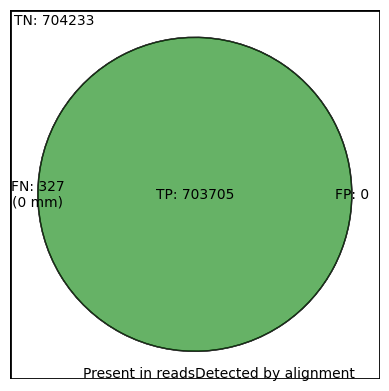

/home/jrich/Desktop/varseek/varseek/utils/visualization_utils.py:267: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby(group_col).sum()


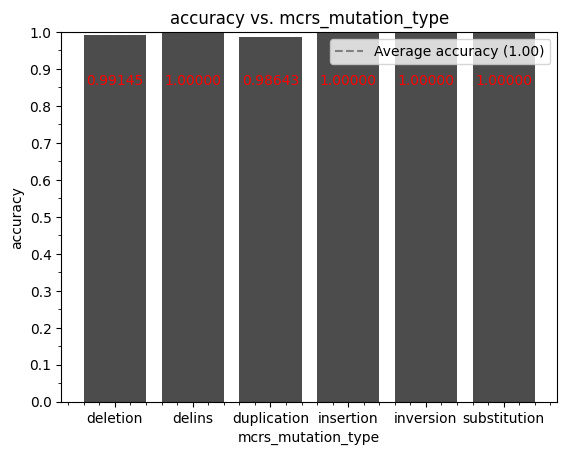

In [13]:
aligned_ids = set(bus_df['read_id'])
read_df['aligned_somewhere'] = read_df['read_id'].isin(aligned_ids)

read_df['TP_crude'] = (read_df['mutant_read'] & read_df['aligned_somewhere'])
read_df['FP_crude'] = (~read_df['mutant_read'] & read_df['aligned_somewhere'])
read_df['FN_crude'] = (read_df['mutant_read'] & ~read_df['aligned_somewhere'])
read_df['TN_crude'] = (~read_df['mutant_read'] & ~read_df['aligned_somewhere'])

metric_dictionary_reads_crude = calculate_metrics(read_df, header_name = "read_header", check_assertions = check_assertions, crude = True, out = f"{plot_output_folder}/reads_metrics_crude.txt")
draw_confusion_matrix(metric_dictionary_reads_crude)

true_set_crude = set(read_df.loc[read_df['mutant_read'], 'read_header'])
positive_set_crude = set(read_df.loc[read_df['aligned_somewhere'], 'read_header'])
create_venn_diagram(true_set_crude, positive_set_crude, TN = metric_dictionary_reads_crude['TN'], mm = n_multimapped, out_path = f"{plot_output_folder}/venn_diagram_read_crude.png")

create_stratified_metric_bar_plot(read_df, 'mcrs_mutation_type', 'accuracy', overall_metric = metric_dictionary_reads_crude['accuracy'], log_x_axis = False, display_numbers = True, crude = True, out_path = f"{plot_output_folder}/accuracy_vs_mcrs_mutation_type_read_perspective_crude.png")

In [14]:
# Merge read_df with bus_df on 'read_id' and 'fastq_header' to bring in 'transcript_ids_list'
merged_df = read_df.merge(bus_df[['read_id', 'transcript_ids_list']], 
                          on='read_id', 
                          how='left')

# Create 'multimapped' column as True if length of 'transcript_ids_list' > 1, else False
read_df['multimapped'] = merged_df['transcript_ids_list'].apply(lambda x: len(x) > 1 if isinstance(x, list) else False)


read_df = read_df.merge(bus_df[['read_id', 'transcript_names_final']], 
                        on='read_id', 
                        how='left').rename(columns={'transcript_names_final': 'mcrs_id_to_which_the_read_aligned'})

# Convert lists to comma-separated strings, keeping NaN values as NaN
read_df['mcrs_id_to_which_the_read_aligned'] = read_df['mcrs_id_to_which_the_read_aligned'].apply(
    lambda x: ','.join(x) if isinstance(x, list) else x
)

TP: 703705, FP: 0, FN: 327, TN: 704233
FNs: ['ENST00000321725:c.4091del_0rM', 'ENST00000321725:c.4091del_1rM', 'ENST00000321725:c.4091del_2rM', 'ENST00000321725:c.4091del_3rM', 'ENST00000321725:c.4091del_4rM', 'ENST00000321725:c.4091del_5rM', 'ENST00000328345:c.415del_0rM', 'ENST00000328345:c.415del_1rM', 'ENST00000328345:c.415del_2rM', 'ENST00000328345:c.415del_3rM', 'ENST00000372715:c.1072dup_0rM', 'ENST00000372715:c.1072dup_1rM', 'ENST00000340370:c.1766_1768del_0rM', 'ENST00000262320:c.701_704del_140fM', 'ENST00000526538:c.492del_139fM', 'ENST00000526538:c.492del_140fM', 'ENST00000270593:c.1045dup_0rM', 'ENST00000361790:c.1978_1980del_140fM', 'ENST00000221466:c.780del_0rM', 'ENST00000221466:c.780del_1rM', 'ENST00000378279:c.446del_137fM', 'ENST00000378279:c.446del_138fM', 'ENST00000378279:c.446del_139fM', 'ENST00000378279:c.446del_140fM', 'ENST00000297508:c.1460del_136fM', 'ENST00000297508:c.1460del_137fM', 'ENST00000297508:c.1460del_138fM', 'ENST00000297508:c.1460del_139fM', 'ENST0

                      Confusion Matrix                       
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃                 ┃ Predicted Positive ┃ Predicted Negative ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Actual Positive │       703705       │        327         │
│ Actual Negative │         0          │       704233       │
└─────────────────┴────────────────────┴────────────────────┘

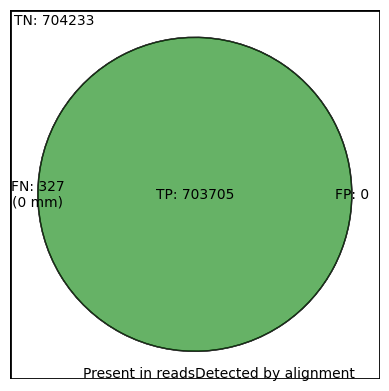

In [15]:
read_df['aligned_to_correct_mcrs'] = (read_df['mcrs_id'] == read_df['mcrs_id_to_which_the_read_aligned'])

# Check if 'mcrs_id' is a substring of any item in 'mcrs_id_to_which_the_read_aligned'
read_df['aligned_to_correct_mcrs_including_multimapped'] = read_df.apply(
    lambda row: row['mcrs_id'] in row['mcrs_id_to_which_the_read_aligned'] 
                if isinstance(row['mcrs_id_to_which_the_read_aligned'], str) else False,
    axis=1
)

read_df['TP'] = (read_df['mutant_read'] & read_df['aligned_to_correct_mcrs'])
read_df['FP'] = (~read_df['mutant_read'] & read_df['aligned_to_correct_mcrs'])
read_df['FN'] = (read_df['mutant_read'] & ~read_df['aligned_to_correct_mcrs'])
read_df['TN'] = (~read_df['mutant_read'] & ~read_df['aligned_to_correct_mcrs'])

metric_dictionary_reads = calculate_metrics(read_df, header_name = "read_header", check_assertions = check_assertions, out = f"{plot_output_folder}/read_metrics.txt")
draw_confusion_matrix(metric_dictionary_reads)

true_set = set(read_df.loc[read_df['mutant_read'], 'read_header'])
positive_set = set(read_df.loc[read_df['aligned_to_correct_mcrs'], 'read_header'])
create_venn_diagram(true_set, positive_set, TN = metric_dictionary_reads['TN'], mm = n_multimapped, out_path = f"{plot_output_folder}/venn_diagram_read.png")

In [16]:
fn_df = read_df.loc[read_df['FN']]
fn_df

,read_id,read_header,read_sequence,read_index,read_strand,reference_header,mcrs_id,mcrs_header,mcrs_mutation_type,mutant_read,wt_read,region_included_in_mcrs_reference,noise_added,aligned_somewhere,TP_crude,FP_crude,FN_crude,TN_crude,multimapped,mcrs_id_to_which_the_read_aligned,aligned_to_correct_mcrs,aligned_to_correct_mcrs_including_multimapped,TP,FP,FN,TN
24270,vcrs_5211236_0rM,ENST00000321725:c.4091del_0rM,TGGGCACAGTCACACACTCCGGTGCAGTTGGGCCCGTAGCGGCCCA...,0,r,ENST00000321725:c.4091del,vcrs_5211236,ENST00000321725:c.4091del,deletion,True,False,True,False,False,False,False,True,False,False,NaN,False,False,False,False,True,False
24271,vcrs_5211236_1rM,ENST00000321725:c.4091del_1rM,GGGCACAGTCACACACTCCGGTGCAGTTGGGCCCGTAGCGGCCCAG...,1,r,ENST00000321725:c.4091del,vcrs_5211236,ENST00000321725:c.4091del,deletion,True,False,True,False,False,False,False,True,False,False,NaN,False,False,False,False,True,False
24272,vcrs_5211236_2rM,ENST00000321725:c.4091del_2rM,GGCACAGTCACACACTCCGGTGCAGTTGGGCCCGTAGCGGCCCAGC...,2,r,ENST00000321725:c.4091del,vcrs_5211236,ENST00000321725:c.4091del,deletion,True,False,True,False,False,False,False,True,False,False,NaN,False,False,False,False,True,False
24273,vcrs_5211236_3rM,ENST00000321725:c.4091del_3rM,GCACAGTCACACACTCCGGTGCAGTTGGGCCCGTAGCGGCCCAGCT...,3,r,ENST00000321725:c.4091del,vcrs_5211236,ENST00000321725:c.4091del,deletion,True,False,True,False,False,False,False,True,False,False,NaN,False,False,False,False,True,False
24274,vcrs_5211236_4rM,ENST00000321725:c.4091del_4rM,CACAGTCACACACTCCGGTGCAGTTGGGCCCGTAGCGGCCCAGCTC...,4,r,ENST00000321725:c.4091del,vcrs_5211236,ENST00000321725:c.4091del,deletion,True,False,True,False,False,False,False,True,False,False,NaN,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682282,vcrs_5224612_141fM,ENST00000361428:c.3259dup_141fM,TATTTATGATGCTGGCAATCACTGGTGCAAAGACTGCAACACCATC...,141,f,ENST00000361428:c.3259dup,vcrs_5224612,ENST00000361428:c.3259dup,duplication,True,False,True,False,False,False,False,True,False,False,NaN,False,False,False,False,True,False
690353,vcrs_5200518_140fM,ENST00000251968:c.556del_140fM,CGATGCAGTTCCAGGGAACTAATGAACCTCACTGGAACAATCCCTG...,140,f,ENST00000251968:c.556del,vcrs_5200518,ENST00000251968:c.556del,deletion,True,False,True,False,False,False,False,True,False,False,NaN,False,False,False,False,True,False
694091,vcrs_5248679_0rM,ENST00000296839:c.804_805dup_0rM,GCCGCAGCCCGGGCGCGGGGACCGGCGCGCGGTGGCTGAGGCGCTT...,0,r,ENST00000296839:c.804_805dup,vcrs_5248679,ENST00000296839:c.804_805dup,duplication,True,False,True,False,False,False,False,True,False,False,NaN,False,False,False,False,True,False
694092,vcrs_5248679_1rM,ENST00000296839:c.804_805dup_1rM,CCGCAGCCCGGGCGCGGGGACCGGCGCGCGGTGGCTGAGGCGCTTG...,1,r,ENST00000296839:c.804_805dup,vcrs_5248679,ENST00000296839:c.804_805dup,duplication,True,False,True,False,False,False,False,True,False,False,NaN,False,False,False,False,True,False


In [17]:
read_df['reason_for_fn'] = np.nan

if check_reason_for_read_fn:
    # Loop through each row in read_df where 'FN' is True
    for index, row in read_df.loc[read_df['FN']].iterrows():
        reason_for_fn_sublist = []

        # Get the mcrs_id from the current row in read_df
        mcrs_id = row['mcrs_id']
        
        # Find the corresponding mcrs_sequence_length in mutation_metadata_df
        matching_length = mutation_metadata_df.loc[
            mutation_metadata_df['mcrs_id'] == mcrs_id, 'mcrs_sequence_length'
        ]
        
        # Check if there's a match and if the length is less than 55
        if not matching_length.empty and matching_length.iloc[0] < (2*k-1):
            reason_for_fn_sublist.append("short_mcrs_id")

        if row['multimapped']:
            reason_for_fn_sublist.append("multimapped")
        
        dlist_status = mutation_metadata_df.loc[
            mutation_metadata_df['mcrs_id'] == mcrs_id, 'dlist'
        ]

        if not dlist_status.empty and dlist_status.iloc[0] != "none":
            reason_for_fn_sublist.append("dlisted")

        if reason_for_fn_sublist:
            read_df.at[index, 'reason_for_fn'] = reason_for_fn_sublist  # might be cast as a string if length == 1 (especially for first row), but this doesn't really matter for me

    num_nan_reasons = read_df.loc[read_df['FN'], 'reason_for_fn'].isna().sum()

    print(f"Number of FN reads with no reasons: {num_nan_reasons}")

In [18]:
# Get the unique mcrs_id values from read_df where FN is True
matching_mcrs_ids = read_df.loc[read_df['FN'], 'mcrs_id'].unique()

# Filter mutation_metadata_df for rows with matching mcrs_id values and access mcrs_sequence_length
matching_mcrs_sequence_lengths = mutation_metadata_df.loc[
    mutation_metadata_df['mcrs_id'].isin(matching_mcrs_ids), 'mcrs_sequence_length'
]

# Perspective of reference

In [19]:
columns_to_list = ["header","order","seq_ID","mutation","mutation_type","wt_sequence","nucleotide_positions","actual_mutation","mutation_cds","mutation_aa","GENOMIC_MUTATION_ID","chromosome","strand","mutation_genome","gene_name","mutation_id","start_mutation_position","end_mutation_position","nucleotide_positions_cdna","actual_mutation_cdna","start_mutation_position_cdna","end_mutation_position_cdna","header_genome","header_cdna","header_cds","nucleotide_positions_genome","actual_mutation_genome","start_mutation_position_genome","end_mutation_position_genome","distance_to_nearest_splice_junction","is_near_splice_junction_10","nearby_mutations","nearby_mutations_count","has_a_nearby_mutation"]
columns_to_or = ["included_in_synthetic_reads_mutant","included_in_synthetic_reads_wt","included_in_synthetic_reads", "any_noisy_reads", "any_noisy_reads_mutant", "any_noisy_reads_wt"]
columns_to_sum = ["list_of_read_starting_indices_mutant","list_of_read_starting_indices_wt","number_of_reads_wt","number_of_reads_mutant","noisy_read_indices_mutant","noisy_read_indices_wt"]
columns_to_all = []

# #!!!TEMP
# drop all columns in columns_to_list
columns_to_list.remove("order")
columns_to_list.remove("distance_to_nearest_splice_junction")
mutation_metadata_df.drop(columns=columns_to_list, inplace=True)
# #!!!TEMP

mutation_metadata_df_original_column_order = mutation_metadata_df.columns
columns_to_list = [col for col in columns_to_list if col in mutation_metadata_df_original_column_order]
columns_to_or = [col for col in columns_to_or if col in mutation_metadata_df_original_column_order]
columns_to_sum = [col for col in columns_to_sum if col in mutation_metadata_df_original_column_order]

for column in list(columns_to_list):
    mutation_metadata_df[column] = mutation_metadata_df[column].apply(
        lambda x: tuple(x) if isinstance(x, list) else x
    )

unique_mcrs_df = (
    mutation_metadata_df.sort_values('order').groupby('mcrs_header', as_index=False)
    .agg(
        {**{col: list for col in list(columns_to_list)},  # list these values
        **{col: sum for col in list(columns_to_sum)},  # Take the first value for these columns
        **{col: np.any for col in list(columns_to_or)},  # OR these values
        **{col: np.all for col in list(columns_to_all)},  # AND these values
        **{col: 'first' for col in mutation_metadata_df.columns if col not in columns_to_list + columns_to_or + columns_to_all + columns_to_sum + ['mcrs_header']}}  # Take the first value for other columns
    ).reset_index(drop=True)
)

unique_mcrs_df = unique_mcrs_df[mutation_metadata_df_original_column_order]

unique_mcrs_df['tumor_purity'] = unique_mcrs_df['number_of_reads_mutant'] / unique_mcrs_df['number_of_reads_wt']

unique_mcrs_df['tumor_purity'] = np.where(
    np.isnan(unique_mcrs_df['tumor_purity']), 
    np.nan,  # Keep NaN as NaN
    unique_mcrs_df['tumor_purity']  # Keep the result for valid divisions
)

try:
    unique_mcrs_df['min_distance_to_splice_junction'] = unique_mcrs_df['distance_to_nearest_splice_junction'].apply(
        lambda x: min(x) if isinstance(x, list) and len(x) > 0 else np.nan
    )
except Exception as e:
    pass

In [20]:
# TODO (very low priority): once I run more complex tests to verify that bus df and adata agree, then I can load in these values from bus df and remove the need to run kb count without mm

adata_path = f"{kb_count_out}/counts_unfiltered/adata.h5ad"
adata = ad.read_h5ad(adata_path)

# Find the indices of non-zero values in adata.X
non_zero_indices = np.nonzero(adata.X)

# Get the non-zero values
non_zero_values = np.squeeze(np.asarray(adata.X[non_zero_indices])).astype(int)

# Get the corresponding gene names
mcrs_ids = adata.var.index[non_zero_indices[1]].to_numpy().flatten()

mcrs_ids = mcrs_ids.astype(str)

# Create a DataFrame
adata_df = pd.DataFrame({
    'mcrs_id': mcrs_ids,
    'number_of_reads_aligned_to_this_item': non_zero_values
})

unique_mcrs_df = unique_mcrs_df.merge(adata_df, on='mcrs_id', how='left')
unique_mcrs_df['received_an_aligned_read'] = ~pd.isna(unique_mcrs_df['number_of_reads_aligned_to_this_item'])

# # set to int - will need to do Int64 to work
# unique_mcrs_df['number_of_reads_mutant'] = unique_mcrs_df['number_of_reads_mutant'].astype(int)
# unique_mcrs_df['number_of_reads_wt'] = unique_mcrs_df['number_of_reads_wt'].astype(int)
# unique_mcrs_df['number_of_reads_aligned_to_this_item'] = unique_mcrs_df['number_of_reads_aligned_to_this_item'].astype(int)

## Temporary detour: make sure bus_df and adata agree

In [21]:
bus_df_subset = bus_df[["transcript_names_final", "counted_in_count_matrix", "count"]]

bus_df_subset['transcript_names_final'] = bus_df_subset['transcript_names_final'].apply(
    lambda x: x[0] if isinstance(x, list) and x else x
)

# Group by the string representation
bus_df_subset_grouped = bus_df_subset.groupby('transcript_names_final', as_index=False).agg({
    'counted_in_count_matrix': 'first',
    'count': 'sum'
})

# Set values in 'count' to 0 where 'counted_in_count_matrix' is False
bus_df_subset_grouped.loc[bus_df_subset_grouped['counted_in_count_matrix'] == False, 'count'] = 0

bus_df_subset_grouped.rename(columns={"transcript_names_final": "mcrs_id", "count": "count_bus"}, inplace=True)

bus_df_subset_grouped = bus_df_subset_grouped.merge(adata_df, on='mcrs_id', how='left')
bus_df_subset_grouped = bus_df_subset_grouped.rename(columns={'number_of_reads_aligned_to_this_item': 'count_adata'})


mismatch_count = (bus_df_subset_grouped['count_bus'] != bus_df_subset_grouped['count_adata']).sum()
print(f"Number of mismatches between BUS file and adata: {mismatch_count}")

Number of mismatches between BUS file and adata: 0


/tmp/ipykernel_2646/2528789349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_df_subset['transcript_names_final'] = bus_df_subset['transcript_names_final'].apply(


TP: 5000, FP: 0, FN: 0, TN: 5295021
Accuracy: 1.0, Sensitivity: 1.0, Specificity: 1.0


                      Confusion Matrix                       
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃                 ┃ Predicted Positive ┃ Predicted Negative ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Actual Positive │        5000        │         0          │
│ Actual Negative │         0          │      5295021       │
└─────────────────┴────────────────────┴────────────────────┘

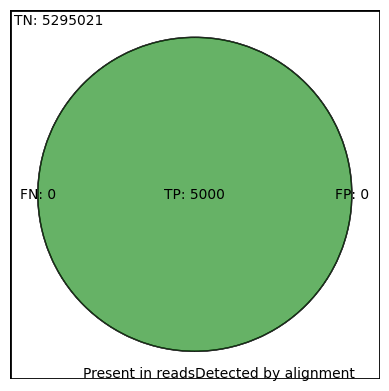

In [22]:
unique_mcrs_df['TP_crude'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read'])
unique_mcrs_df['FP_crude'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read'])
unique_mcrs_df['FN_crude'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read'])
unique_mcrs_df['TN_crude'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read'])

metric_dictionary_reference = calculate_metrics(unique_mcrs_df, header_name = "mcrs_header", check_assertions = check_assertions, crude = True, out = f"{plot_output_folder}/reference_metrics_crude.txt")
draw_confusion_matrix(metric_dictionary_reference)

true_set = set(unique_mcrs_df.loc[unique_mcrs_df['included_in_synthetic_reads_mutant'], 'mcrs_header'])
positive_set = set(unique_mcrs_df.loc[unique_mcrs_df['received_an_aligned_read'], 'mcrs_header'])
create_venn_diagram(true_set, positive_set, TN = metric_dictionary_reference['TN'], out_path = f"{plot_output_folder}/venn_diagram_reference_crude.png")

In [23]:
aligned_read_df_mutant = read_df.loc[(read_df['aligned_somewhere'] == True) & (read_df['mutant_read'] == True)]
mcrs_counts_mutant = aligned_read_df_mutant.groupby('mcrs_id').size().reset_index(name='number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere')

unique_mcrs_df = unique_mcrs_df.merge(mcrs_counts_mutant, on='mcrs_id', how='left')
unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].fillna(0).astype(int)
unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_didnt_align_anywhere'] = unique_mcrs_df['number_of_reads_mutant'] - unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere']

unique_mcrs_df['mutation_expression_prediction_error'] = unique_mcrs_df['number_of_reads_aligned_to_this_item'] - unique_mcrs_df['number_of_reads_mutant']  # positive means overpredicted, negative means underpredicted




aligned_read_df_wt = read_df.loc[(read_df['aligned_somewhere'] == True) & (read_df['wt_read'] == True)]
mcrs_counts_wt = aligned_read_df_wt.groupby('mcrs_id').size().reset_index(name='number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere')

unique_mcrs_df = unique_mcrs_df.merge(mcrs_counts_wt, on='mcrs_id', how='left')
unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].fillna(0).astype(int)
unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_didnt_align_anywhere'] = unique_mcrs_df['number_of_reads_wt'] - unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere']

In [24]:
# Step 1: Group by 'mcrs_header' and count 'aligned_to_correct_mcrs' (sum will count True as 1, False as 0)
aligned_counts = read_df.groupby('mcrs_header')['aligned_to_correct_mcrs'].sum().reset_index()

# Rename the column to something meaningful, like 'correct_alignment_count'
aligned_counts.rename(columns={'aligned_to_correct_mcrs': 'number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly'}, inplace=True)

# Step 2: Merge the counts with unique_mcrs_df on the 'mcrs_header' column
unique_mcrs_df = pd.merge(unique_mcrs_df, aligned_counts, on='mcrs_header', how='left')

# Fill NaN values with 0 in case some mcrs_header values in unique_mcrs_df do not appear in read_df
unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly'].fillna(0, inplace=True)

unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'] = unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly'] > 0

In [25]:
# Step 1: Group by 'mcrs_header_to_which_the_read_aligned' and collect 'read_header' into lists
reads_mapped = read_df.groupby('mcrs_id_to_which_the_read_aligned')['read_header'].apply(list).reset_index()

# Rename the column to 'reads_mapped_to_this_reference_item' for clarity
reads_mapped.rename(columns={'read_header': 'reads_mapped_to_this_reference_item'}, inplace=True)

# Step 2: Merge the list of read headers with unique_mcrs_df on the 'mcrs_header' column
unique_mcrs_df = pd.merge(unique_mcrs_df, reads_mapped, left_on='mcrs_id', right_on='mcrs_id_to_which_the_read_aligned', how='left')
unique_mcrs_df.drop(columns='mcrs_id_to_which_the_read_aligned', inplace=True)

# Fill NaN values with empty lists in case there are no matching read headers for some mcrs_header values
unique_mcrs_df['reads_mapped_to_this_reference_item'] = unique_mcrs_df['reads_mapped_to_this_reference_item'].apply(lambda x: x if isinstance(x, list) else [])

unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].astype(bool)
unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].astype(bool)

TP: 5000, FP: 0, FN: 0, TN: 5295021
Accuracy: 1.0, Sensitivity: 1.0, Specificity: 1.0


                      Confusion Matrix                       
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃                 ┃ Predicted Positive ┃ Predicted Negative ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Actual Positive │        5000        │         0          │
│ Actual Negative │         0          │      5295021       │
└─────────────────┴────────────────────┴────────────────────┘

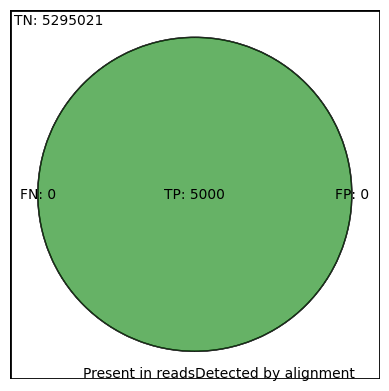

/home/jrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7037: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)
/home/jrich/Desktop/varseek/varseek/utils/visualization_utils.py:472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].abs()


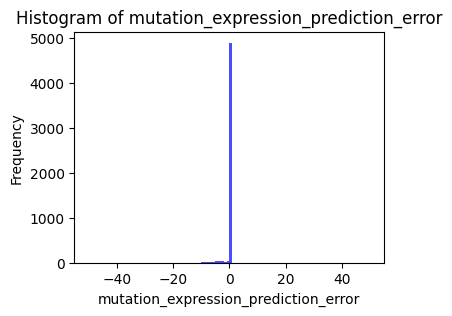

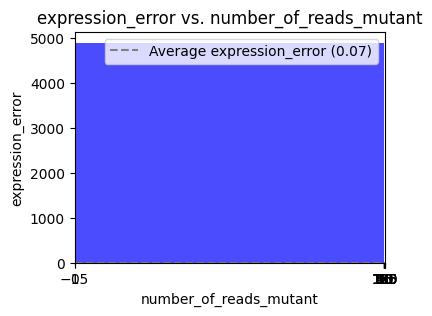

/home/jrich/Desktop/varseek/varseek/utils/visualization_utils.py:267: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby(group_col).sum()


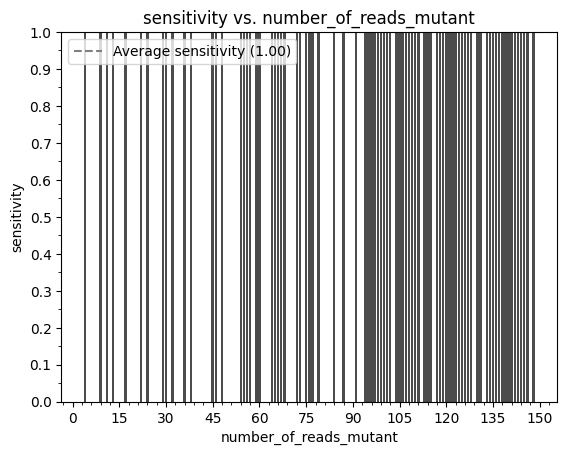

In [26]:
unique_mcrs_df['TP'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])
unique_mcrs_df['FP'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])
unique_mcrs_df['FN'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])
unique_mcrs_df['TN'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])

metric_dictionary_reference = calculate_metrics(unique_mcrs_df, header_name = "mcrs_header", check_assertions = check_assertions, out = f"{plot_output_folder}/reference_metrics.txt")
draw_confusion_matrix(metric_dictionary_reference)

true_set = set(unique_mcrs_df.loc[unique_mcrs_df['included_in_synthetic_reads_mutant'], 'mcrs_header'])
positive_set = set(unique_mcrs_df.loc[unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'], 'mcrs_header'])
create_venn_diagram(true_set, positive_set, TN = metric_dictionary_reference['TN'], out_path = f"{plot_output_folder}/venn_diagram_reference.png")

unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_did_not_align_correctly'] = unique_mcrs_df['number_of_reads_mutant'] - unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly']
unique_mcrs_df['number_of_reads_aligned_to_this_mcrs_item_that_aligned_incorrectly'] = unique_mcrs_df['number_of_reads_aligned_to_this_item'] - unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly']

plot_histogram(unique_mcrs_df.loc[~unique_mcrs_df['TN']], 'mutation_expression_prediction_error', log_scale = False, out_path = f"{plot_output_folder}/histogram_mutation_expression_prediction_error_linear_axis.png")
plot_histogram(unique_mcrs_df.loc[~unique_mcrs_df['TN']], 'mutation_expression_prediction_error', log_scale = True, out_path = f"{plot_output_folder}/histogram_mutation_expression_prediction_error_log_axis.png")

metric_dictionary_reference['mutation_expression_prediction_error_abs_mean'] = unique_mcrs_df.loc[~unique_mcrs_df['TN'], 'mutation_expression_prediction_error'].abs().mean()
create_stratified_metric_bar_plot(unique_mcrs_df, 'number_of_reads_mutant', 'expression_error', overall_metric = metric_dictionary_reference['mutation_expression_prediction_error_abs_mean'], log_x_axis = False, out_path = f"{plot_output_folder}/expression_error_vs_number_of_reads_mutant.png")
# create_stratified_metric_bar_plot(unique_mcrs_df, 'min_distance_to_splice_junction', 'accuracy', overall_metric = metric_dictionary_reference['accuracy'], log_x_axis = False, bins = [-1, 0, 1, 5, 10, 50, 100, float('inf')])
create_stratified_metric_bar_plot(unique_mcrs_df, 'number_of_reads_mutant', 'sensitivity', overall_metric = metric_dictionary_reference['sensitivity'], log_x_axis = False, out_path = f"{plot_output_folder}/accuracy_vs_number_of_reads_mutant.png")
#* add more here
#*** create similar plots for y in {sensitivity, specificity}, and x in {number_of_reads_wt, tumor_purity} and determine cutoffs for which varseek is reliable

In [27]:
import importlib
import varseek.utils.visualization_utils
importlib.reload(varseek.utils.visualization_utils)
from varseek.utils.visualization_utils import create_stratified_metric_bar_plot

/home/jrich/Desktop/varseek/varseek/utils/visualization_utils.py:267: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby(group_col).sum()


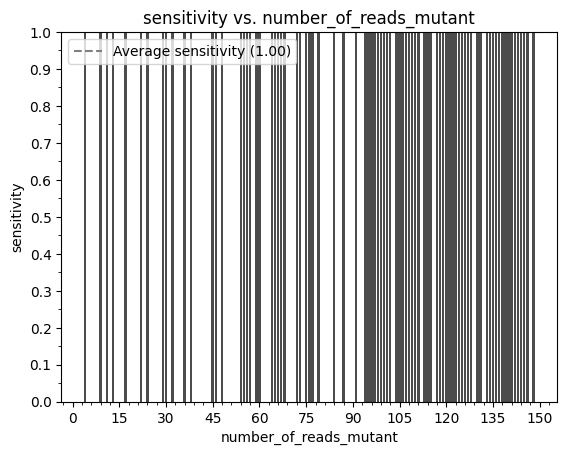

In [28]:
create_stratified_metric_bar_plot(unique_mcrs_df, 'number_of_reads_mutant', 'sensitivity', overall_metric = metric_dictionary_reference['sensitivity'], log_x_axis = False, out_path = f"{plot_output_folder}/accuracy_vs_number_of_reads_mutant.png")

In [29]:
unexplainable_references = 0
for header in metric_dictionary_reference['FNs']:
    print(f"Header {header}")
    did_not_align_anywhere = (read_df[read_df['mcrs_header'] == header])['FN_crude'].all()
    print(f"All did not align anywhere for {header}: {did_not_align_anywhere}")
    did_not_align_to_correct_position = (read_df[read_df['mcrs_header'] == header])['FN'].all()
    print(f"All did not align to correct mcrs for {header}: {did_not_align_to_correct_position}")
    multimapped = (read_df[read_df['mcrs_header'] == header])['multimapped'].all()
    print(f"All multimapped for {header}: {multimapped}")
    if not did_not_align_anywhere and not did_not_align_to_correct_position and not multimapped:
        unexplainable_references += 1

if unexplainable_references > 0:
    print(f"Unexplainable references: {unexplainable_references}")
else:
    print("All explainable!")

All explainable!


In [30]:
unique_mcrs_df.to_csv(unique_mcrs_df_out, index=False)
read_df.to_csv(read_df_out_updated, index=False)

In [31]:
print(read_df.columns)
print(unique_mcrs_df.columns)
print(mutation_metadata_df.columns)

Index(['read_id', 'read_header', 'read_sequence', 'read_index', 'read_strand',
       'reference_header', 'mcrs_id', 'mcrs_header', 'mcrs_mutation_type',
       'mutant_read', 'wt_read', 'region_included_in_mcrs_reference',
       'noise_added', 'aligned_somewhere', 'TP_crude', 'FP_crude', 'FN_crude',
       'TN_crude', 'multimapped', 'mcrs_id_to_which_the_read_aligned',
       'aligned_to_correct_mcrs',
       'aligned_to_correct_mcrs_including_multimapped', 'TP', 'FP', 'FN', 'TN',
       'reason_for_fn'],
      dtype='object')
Index(['mcrs_header', 'order', 'distance_to_nearest_splice_junction',
       'mcrs_sequence', 'mutant_sequence_rc', 'mcrs_id', 'header_list',
       'order_list', 'mcrs_source', 'header_with_gene_name',
       'number_of_mutations_in_this_gene_total', 'mcrs_header_length',
       'mcrs_sequence_length', 'dlist', 'dlist_substring',
       'number_of_alignments_to_normal_human_reference_cdna',
       'number_of_alignments_to_normal_human_reference_genome',
      

In [32]:
# eg /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_temp/plots/read_metrics.txt or /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_temp/plots/reference_metrics.txt
# no_noise_read_metrics = ""
# substitution_noise_read_metrics = ""
# deletion_noise_read_metrics = ""
# insertion_noise_read_metrics = ""
# all_noise_read_metrics = ""
# metric = "accuracy"

# from varseek.utils import retrieve_value_from_metric_file

# accuracy_dict = {}
# accuracy_dict['No Noise'] = retrieve_value_from_metric_file(metric, no_noise_read_metrics)
# accuracy_dict['Substitution Noise'] = retrieve_value_from_metric_file(metric, substitution_noise_read_metrics)
# accuracy_dict['Deletion Noise'] = retrieve_value_from_metric_file(metric, deletion_noise_read_metrics)
# accuracy_dict['Insertion Noise'] = retrieve_value_from_metric_file(metric, insertion_noise_read_metrics)
# accuracy_dict['All Noise'] = retrieve_value_from_metric_file(metric, all_noise_read_metrics)

# from matplotlib import pyplot as plt

# plot_basic_bar_plot_from_dict(accuracy_dict, y_axis=metric)

## Validating with kb extract

In [33]:
# kb_extract_out_all_slow = f"{out_dir_notebook}/kb_extract_out_all_slow"
# df_extract_combined = pd.DataFrame(columns=['read_id', 'mcrs_id_to_which_the_read_aligned_kb_extract'])

# if strand is None or strand == "both":
#     strand_kb_extract = "unstranded"
# elif strand == "f":
#     strand_kb_extract = "forward"
# elif strand == "r":
#     strand_kb_extract = "reverse"

# # # running with --extract_all will make all ~5.3M reference items as the targets, which is much longer than manually defining the list of mutations as my targets - but I would imagine the outcome is the same; also, extract_all will output all files at once rather than one at a time (not good if I want to check progress throughout or break up for multithreading, but it can avoid the issue where mcrs_string_with_aligned_reads is too many characters)
# # kb_extract_command = f"kb extract --strand {strand_kb_extract} --verbose -k {k} -t {threads} --extract_all -o {kb_extract_out_all_slow} -i {mutation_index} -g {mutation_t2g} {synthetic_reads_fastQ}"
# adata_path = f"{kb_count_out}/counts_unfiltered/adata.h5ad"
# mapped_mutations_string = find_genes_with_aligned_reads_for_kb_extract(adata_path)
# mcrs_set_with_aligned_reads = set(mapped_mutations_string.split())
# mcrs_string_with_aligned_reads = ' '.join(f"'{x}'" for x in mcrs_set_with_aligned_reads)
# kb_extract_command = f"kb extract --verbose -k {k} --mm -t {threads} --targets {mcrs_string_with_aligned_reads} -o {kb_extract_out_all_slow} -i {mutation_index} -g {mutation_t2g} {synthetic_reads_fastQ}"

# print(kb_extract_command)

run the command in tmux!

In [34]:
# if 'bus_df' not in globals():
#     from varseek.utils import make_bus_df
#     bus_df = make_bus_df(kallisto_out = kb_count_out_mm, fastq_file = synthetic_reads_fastQ, t2g_file = mutation_t2g, mm = True, union = False, assay = "bulk", bustools = "/home/jrich/miniconda3/envs/varseek/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools")
#     bus_df.rename(columns={"fastq_header": "read_id"}, inplace=True)

# # add some code here to check where these map
# for subdir in os.listdir(kb_extract_out_all_slow):
#     subdir_path = os.path.join(kb_extract_out_all_slow, subdir)
#     if os.path.isdir(subdir_path):
#         fastq_file = os.path.join(subdir_path, '1.fastq.gz')
#         if os.path.exists(fastq_file):
#             # Run get_header_set_from_fastq for the fastq file
#             aligned_reads_kb_extract = get_header_set_from_fastq(fastq_file)
#             df_temp = pd.DataFrame(aligned_reads_kb_extract, columns=['read_id'])
#             df_temp['mcrs_id_to_which_the_read_aligned_kb_extract'] = subdir  # Add subdirectory info
#             df_extract_combined = pd.concat([df_extract_combined, df_temp], ignore_index=True)  # Concatenate the new DataFrame with df_extract_combined

# df_extract_combined = df_extract_combined.groupby('read_id')['mcrs_id_to_which_the_read_aligned_kb_extract'].apply(list).reset_index()

# df_extract_combined = df_extract_combined.merge(bus_df[["read_id", "gene_names_final"]], on='read_id', how='left')
# df_extract_combined.rename(columns={"gene_names_final": "mcrs_id_to_which_the_read_aligned_bus_df"}, inplace=True)
# mismatch_count_kb_extract = (df_extract_combined['mcrs_id_to_which_the_read_aligned_bus_df'] != df_extract_combined['mcrs_id_to_which_the_read_aligned_kb_extract']).sum()
# print(f"Number of mismatches between BUS file and kb extract: {mismatch_count_kb_extract}")